In [4]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
%matplotlib inline

In [3]:
plt.style.use('court.mplstyle')

In [6]:
highmass_rc_newvals = pd.read_csv('../datatables/highmass_rc_newvals.csv')
highmass_rc_newvals

,KIC,numax,pysyd_numax,e_pysyd_numax,new_numax,smooth_numax,Delnu,pysyd_dnu,e_pysyd_dnu,o_Teff,...,a_log(g),a_log(g)_e,a_[Fe/H],a_[Fe/H]_e,L_Teff,L_Teff_e,L_log(g),L_log(g)_e,L_[Fe/H],L_[Fe/H]_e
0,3347458,39.99,40.291621,0.904390,40.32,41.422682,3.360,3.362861,0.016179,5000,...,2.525,0.039,0.165,0.007,NaN,NaN,NaN,NaN,NaN,NaN
1,8378545,48.82,47.769061,1.989659,48.07,48.952072,3.952,3.966159,0.022203,5058,...,3.142,0.059,0.157,0.007,5009.00,32.00,2.761,0.053,0.323,0.030
2,5978324,49.10,48.776551,0.974408,48.78,50.072904,4.024,4.072667,0.016443,5051,...,2.701,0.050,-0.098,0.008,NaN,NaN,NaN,NaN,NaN,NaN
3,10068490,66.42,58.662513,1.977989,58.84,60.906533,5.206,5.239133,0.046630,5189,...,2.769,0.062,-0.201,0.010,5254.75,37.05,2.699,0.061,-0.216,0.035
4,4756133,80.81,80.362852,2.357250,80.29,83.967767,5.865,5.998605,0.022750,5152,...,3.014,0.056,0.091,0.008,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,10162765,88.56,85.502602,2.118024,85.53,89.092562,6.760,6.801791,0.023959,4948,...,2.858,0.049,0.076,0.008,5099.89,22.44,2.974,0.034,0.085,0.018
111,3430048,35.82,33.626875,2.147042,33.63,37.856607,3.487,3.518327,0.034631,5079,...,2.502,0.039,0.106,0.007,NaN,NaN,NaN,NaN,NaN,NaN
112,7116721,50.86,50.988298,1.581224,50.97,53.768334,4.522,4.514956,0.013743,5028,...,NaN,NaN,NaN,NaN,4798.39,26.51,2.677,0.044,0.049,0.025
113,7347076,90.59,90.713242,1.757715,90.65,94.236618,7.216,7.217619,0.034534,5386,...,NaN,NaN,NaN,NaN,5076.47,46.21,2.915,0.076,-0.007,0.044


In [11]:
def read_star_hp(star_name,suppress_output=True,unpack=False):
    delta_nu = highmass_rc_newvals['pysyd_dnu'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
    nu_max = highmass_rc_newvals['pysyd_numax'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
    if suppress_output == False:
        print(star_name)
        print('delta_nu =',delta_nu)
        print('nu_max =',nu_max)
    
    lightcurve = pd.read_csv('../data/hpfiltered_LCs/KIC'+star_name[4:]+'_LC.csv')
    powerspec = pd.read_csv('../data/hpfiltered_LCs/KIC'+star_name[4:]+'_PS.csv')
    if unpack == True:
        if suppress_output == False:
            print('unpacking data frames')
        time = np.asarray(lightcurve['time'])
        flux = np.asarray(lightcurve['flux'])
        freq = np.asarray(powerspec['freq'])
        power = np.asarray(powerspec['power'])
        amp = np.asarray(powerspec['amp'])
        return delta_nu,nu_max,time,flux,freq,power,amp
    else:
        if suppress_output == False:
            print('returning dataframes')
        return delta_nu,nu_max,lightcurve,powerspec

In [7]:
def yl_echelle(x, y, period, fmin=None, fmax=None, echelletype="single", offset=0.0):
    '''
    Make an echelle plot used in asteroseismology.
    
    Input parameters
    ----
    x: 1d array-like, freq
    y: 1d array-like, power spectrum
    period: float, length of each vertical stack (Dnu in a frequency echelle, DPi in a period echelle)
    fmin: float, minimum frequency to be plotted
    fmax: float, maximum frequency to be plotted
    echelletype: str, `single` or `replicated`
    offset: float, an amount by which the diagram is shifted horizontally
    
    Return
    ----
    z: a 2d numpy.array, folded power spectrum
    extent: a list, edges (left, right, bottom, top) 
    
    Users can create an echelle diagram with the following command:
    ----
    
    import matplotlib.pyplot as plt
    z, ext = echelle(freq, power, Dnu, fmin=numax-4*Dnu, fmax=numax+4*Dnu)
    plt.imshow(z, extent=ext, aspect='auto', interpolation='nearest')
    
    '''
    
    if fmin is None: fmin=0.
    if fmax is None: fmax=np.nanmax(x)

    fmin = fmin - offset
    fmax = fmax - offset
    x = x - offset

    fmin = 0.0 if fmin<0. else fmin - (fmin % period)

    # define plotting elements
    resolution = np.median(np.diff(x))
    # number of vertical stacks
    n_stack = int((fmax-fmin)/period) 
    # number of point per stack
    n_element = int(period/resolution) 

    fstart = fmin - (fmin % period)
    
    z = np.zeros([n_stack, n_element])
    base = np.linspace(0, period, n_element) if echelletype=='single' else np.linspace(0, 2*period, n_element)
    for istack in range(n_stack):
        z[-istack-1,:] = np.interp(fmin+istack*period+base, x, y)
    
    extent = (0, period, fstart, fstart+n_stack*period) if echelletype=='single' else (0, 2*period, fstart, fstart+n_stack*period)
        
    return z, extent

In [9]:
def echelle_wrapper(freq,power,dnu,fmin,fmax,smooth_percent=0.02):
    fig,ax = plt.subplots(figsize=(8,8))
#     ax1 = fig.add_subplot(111)
    freq_res = np.median(np.diff(freq))
    power = convolve(power, Box1DKernel((dnu*smooth_percent)/freq_res))
#     z, ext = yl_echelle(freq,power,dnu,fmin,fmax, echelletype="replicated")
    z, ext = yl_echelle(freq, power, dnu, fmin=fmin, fmax=fmax, echelletype="replicated")
    z = np.sqrt(z) #sqrt scaling
    ax.imshow(z, extent=ext, aspect='auto', interpolation='nearest', cmap='BuPu')
#     ax.imshow(echz,aspect="auto",
#               extent=(echx.min(), echx.max(), echy.min(), echy.max()),
#               origin="lower",cmap='BuPu')
    ax.axvline(dnu,color='grey',linestyle='--',alpha=0.5)
    ax.set_xlabel("Frequency mod "+str("{0:.3f}").format(dnu) + " ($\mu$Hz)")

In [25]:
from ipywidgets import interact, IntSlider, FloatSlider, fixed
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel

KIC 3347458
delta_nu = 3.362860546
nu_max = 40.29162051
returning dataframes


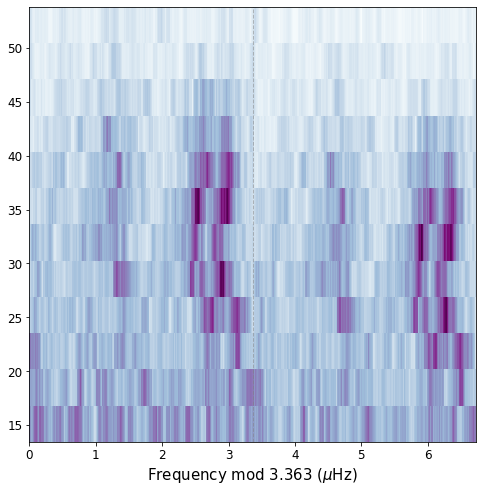

KIC 8378545
delta_nu = 3.966159149
nu_max = 47.76906119
returning dataframes


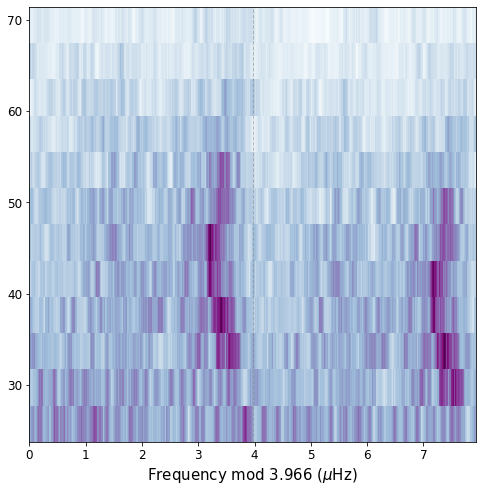

KIC 5978324
delta_nu = 4.072666568
nu_max = 48.77655086
returning dataframes


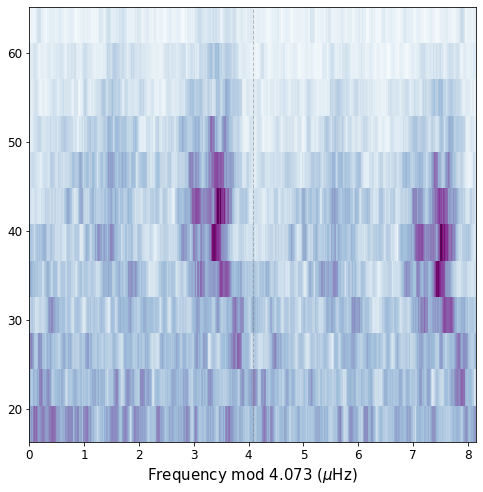

KIC 10068490
delta_nu = 5.239133186
nu_max = 58.662513
returning dataframes


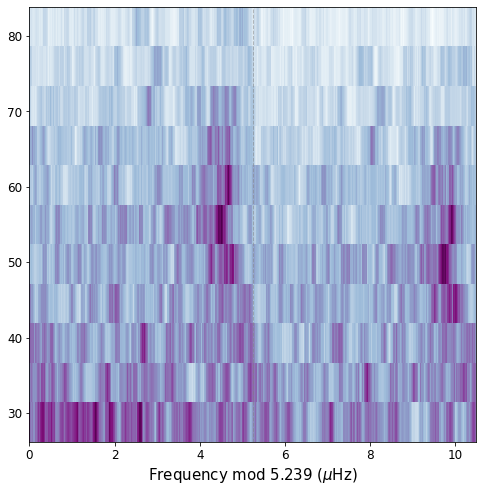

KIC 4756133
delta_nu = 5.998605309
nu_max = 80.36285179
returning dataframes


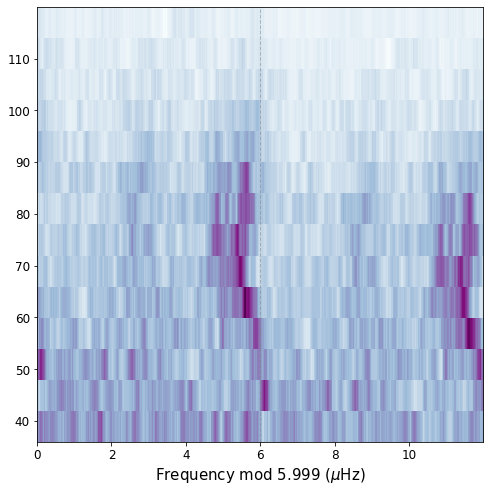

KIC 7175316
delta_nu = 3.730428817
nu_max = 41.48800726
returning dataframes


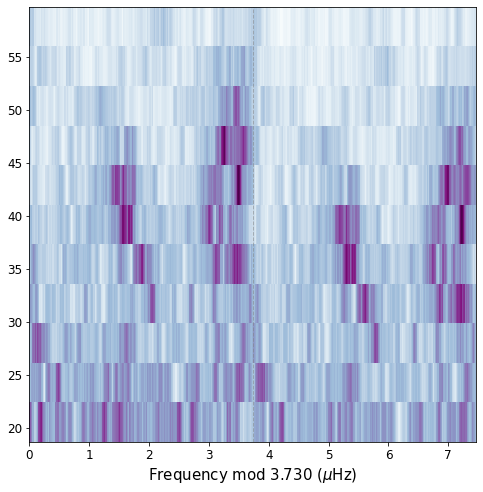

KIC 7024018
delta_nu = 6.639096698
nu_max = 80.55175094
returning dataframes


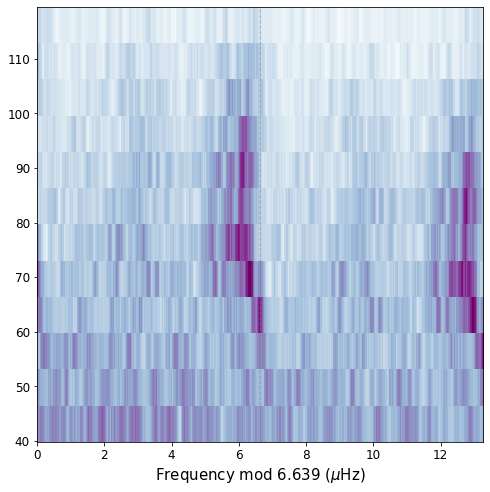

KIC 6547176
delta_nu = 4.086520875
nu_max = 43.03859571
returning dataframes


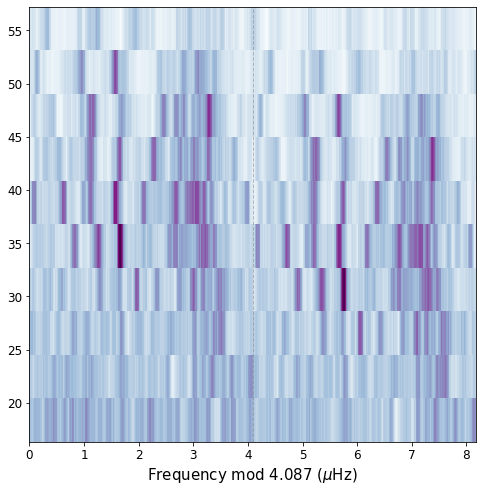

KIC 8621290
delta_nu = 5.425330358
nu_max = 64.8569874
returning dataframes


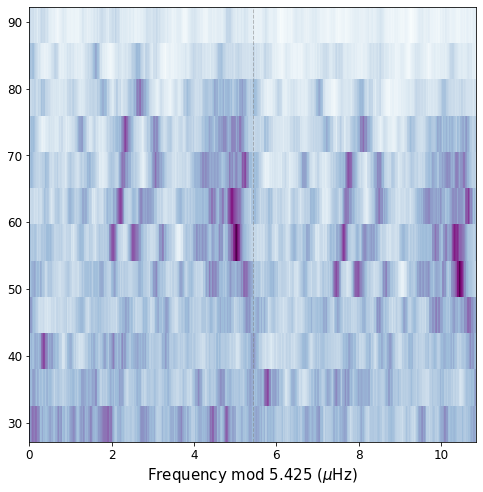

KIC 10384595
delta_nu = 4.764084258
nu_max = 47.58802372
returning dataframes


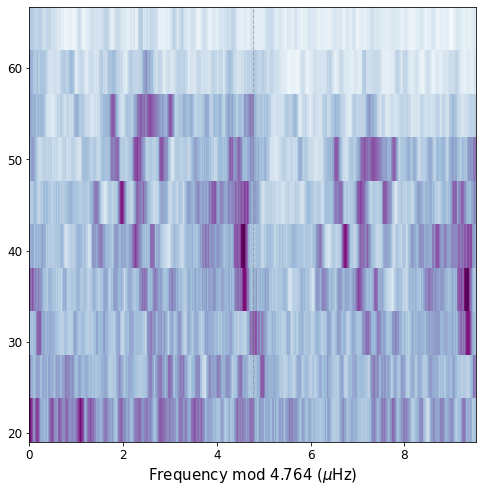

KIC 6599955
delta_nu = 5.870093442
nu_max = 75.7110906
returning dataframes


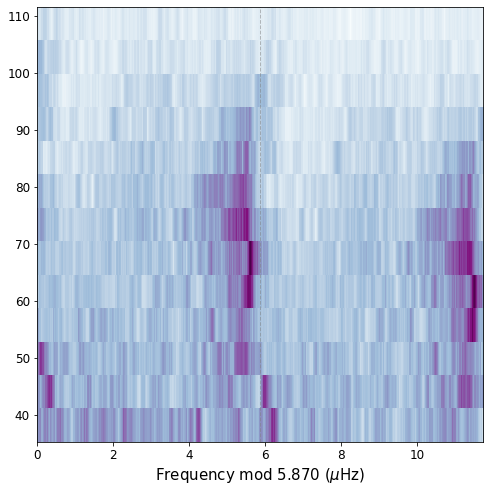

KIC 3955502
delta_nu = 2.516170954
nu_max = 24.71456259
returning dataframes


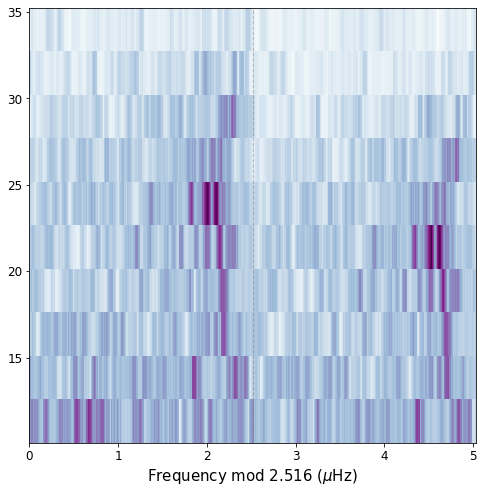

KIC 8037930
delta_nu = 4.776809297
nu_max = 54.42168115
returning dataframes


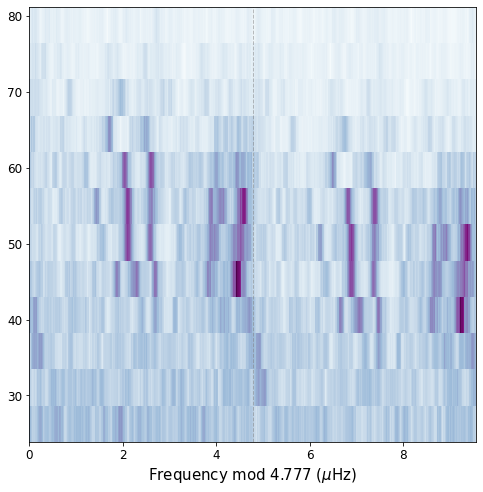

KIC 8569885
delta_nu = 4.024211373
nu_max = 44.92763217
returning dataframes


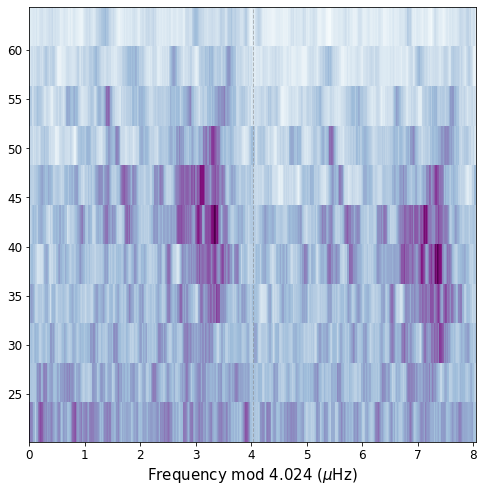

KIC 3747623
delta_nu = 4.317942932
nu_max = 29.27027048
returning dataframes


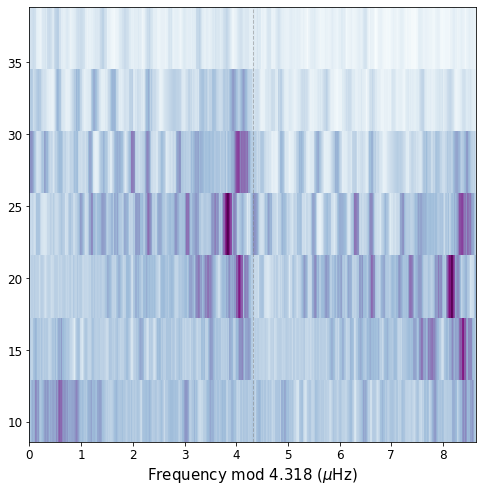

KIC 6529078
delta_nu = 3.977589767
nu_max = 31.84270529
returning dataframes


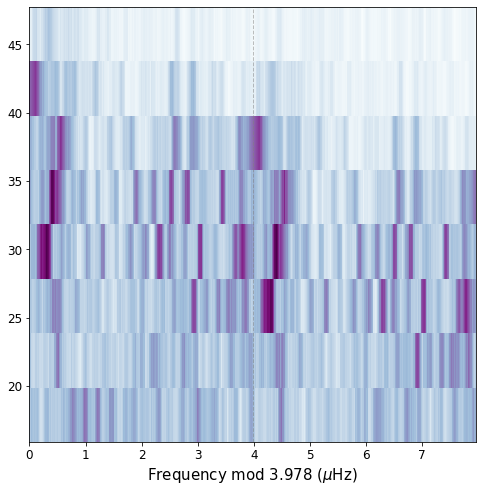

KIC 11518639
delta_nu = 4.610576558
nu_max = 56.14959081
returning dataframes


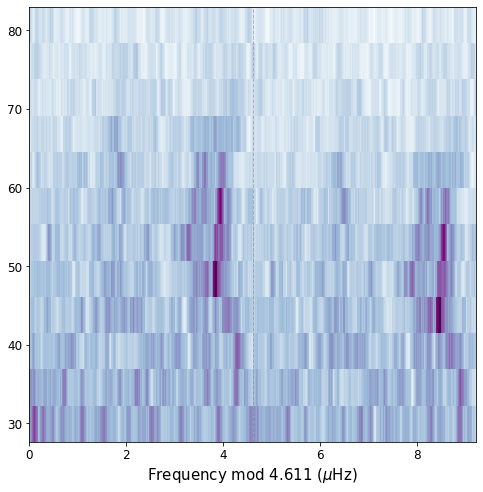

KIC 7988900
delta_nu = 4.127937976
nu_max = 47.73757795
returning dataframes


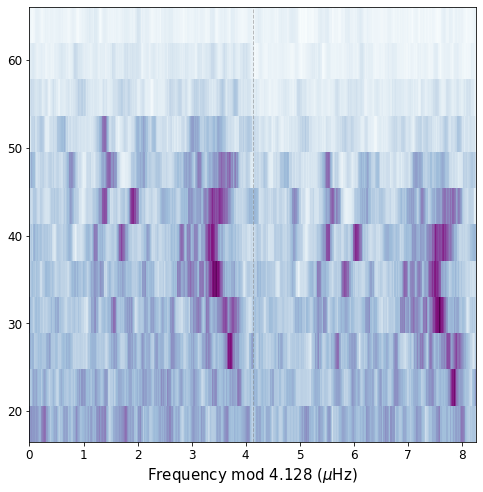

KIC 8365782
delta_nu = 6.298076484
nu_max = 78.48954909
returning dataframes


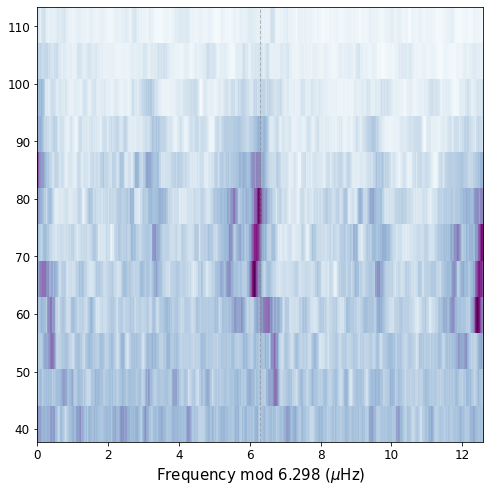

KIC 9612933
delta_nu = 4.432696858
nu_max = 52.46804315
returning dataframes


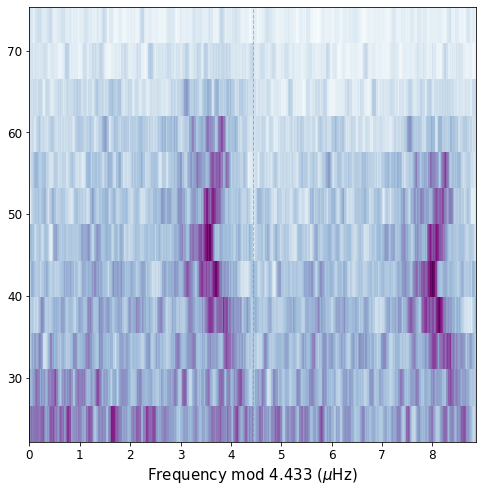

KIC 7971558
delta_nu = 2.877087941
nu_max = 28.10731901
returning dataframes


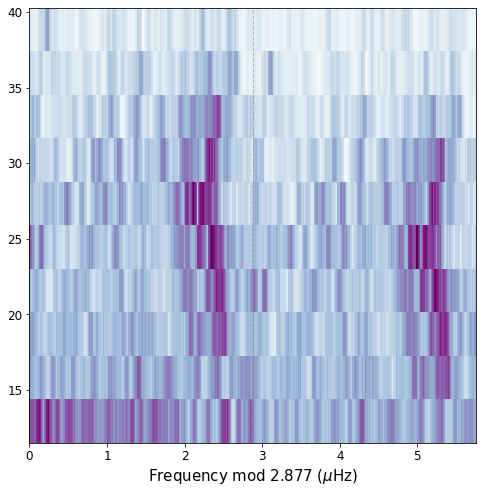

KIC 10547065
delta_nu = 3.790061265
nu_max = 40.83524324
returning dataframes


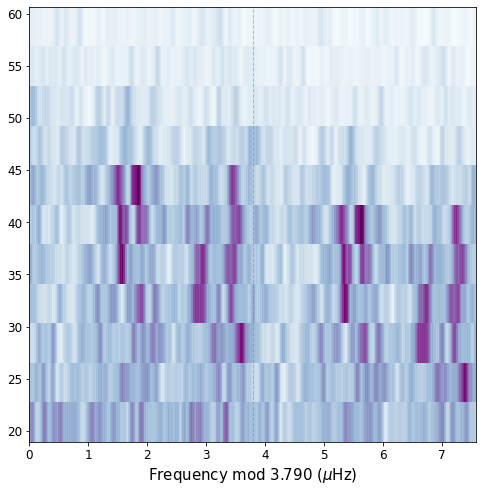

KIC 10094550
delta_nu = 4.844474207
nu_max = 56.47437803
returning dataframes


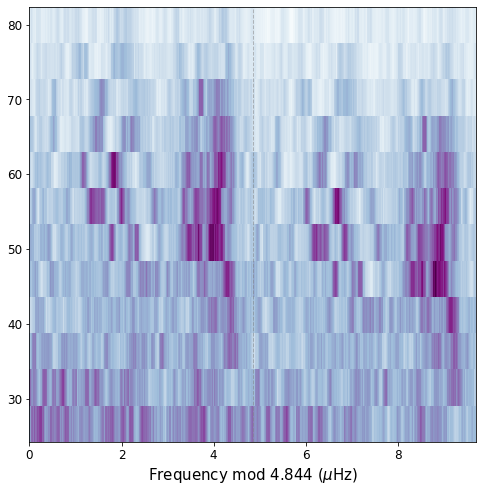

KIC 10736390
delta_nu = 5.80222533
nu_max = 71.81494249
returning dataframes


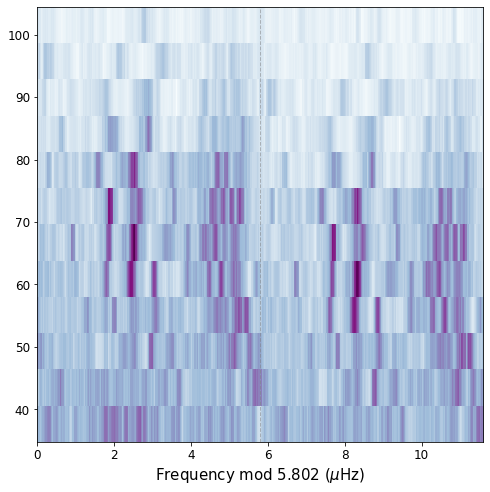

KIC 3758458
delta_nu = 5.875083557
nu_max = 67.04513044
returning dataframes


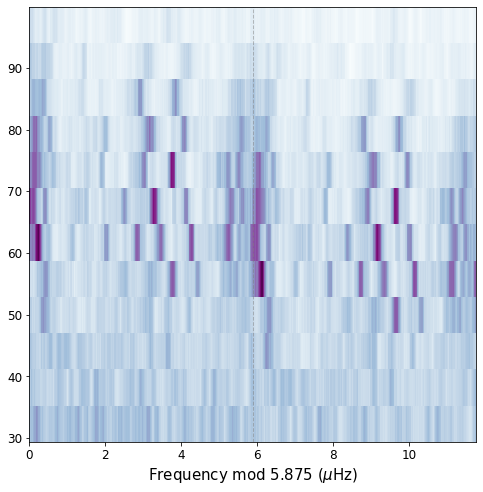

KIC 5564131
delta_nu = 3.631712456
nu_max = 37.89449266
returning dataframes


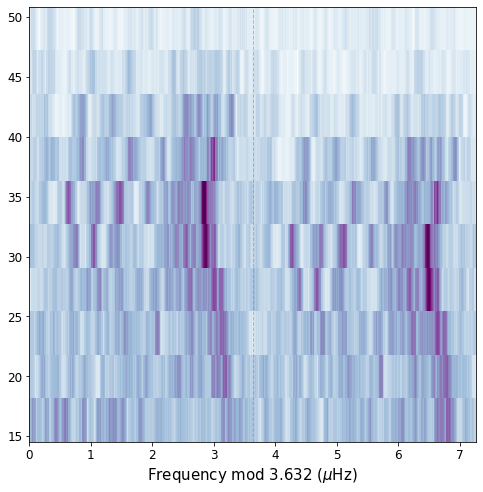

KIC 4370592
delta_nu = 4.420424226
nu_max = 50.02689728
returning dataframes


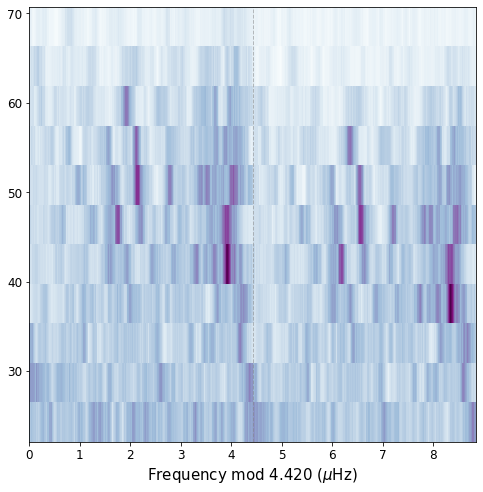

KIC 5097690
delta_nu = 4.989400844
nu_max = 59.04032742
returning dataframes


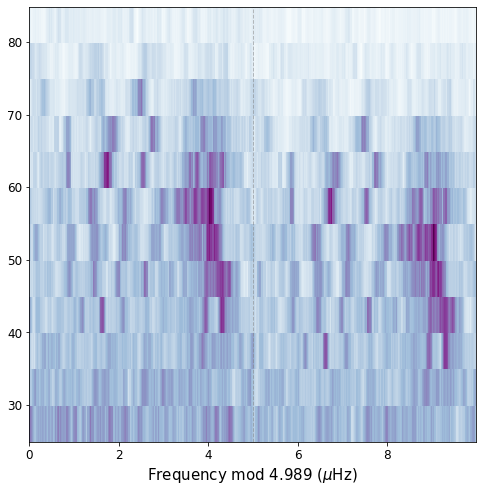

KIC 9286851
delta_nu = 6.627442492
nu_max = 85.49473209
returning dataframes


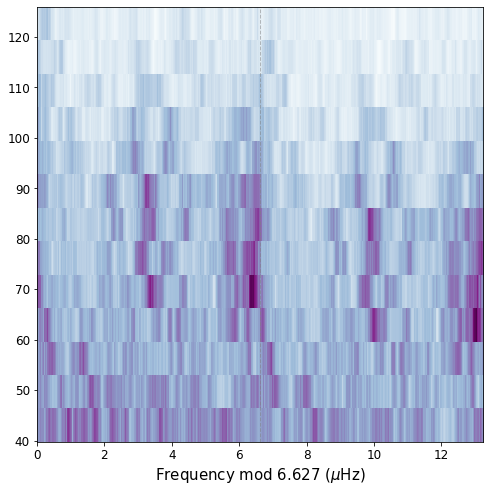

KIC 6866251
delta_nu = 7.199573895
nu_max = 94.23153966
returning dataframes


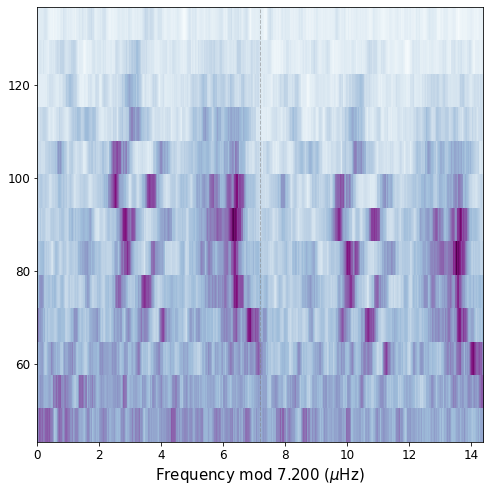

KIC 5106376
delta_nu = 5.191475262
nu_max = 61.69285281
returning dataframes


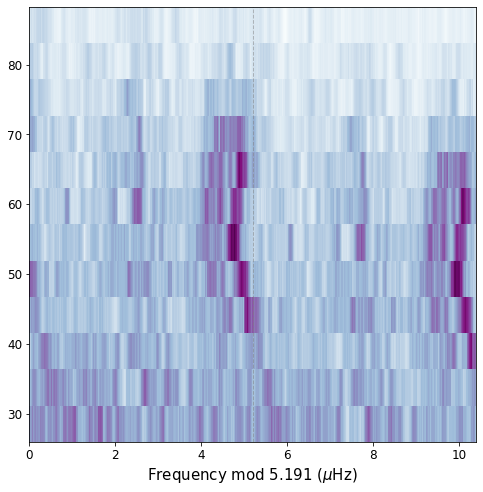

KIC 4562675
delta_nu = 5.40343515
nu_max = 65.28202648
returning dataframes


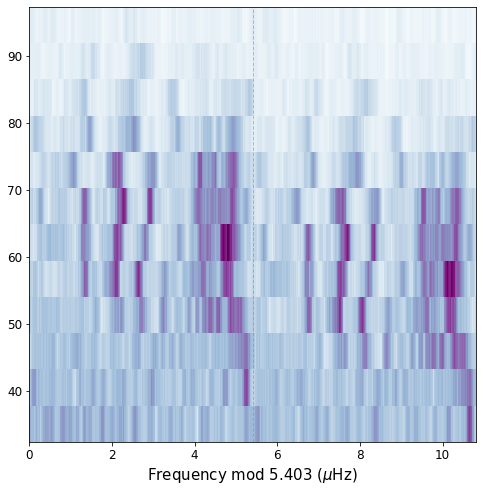

KIC 8525150
delta_nu = 5.660189659
nu_max = 71.68901144
returning dataframes


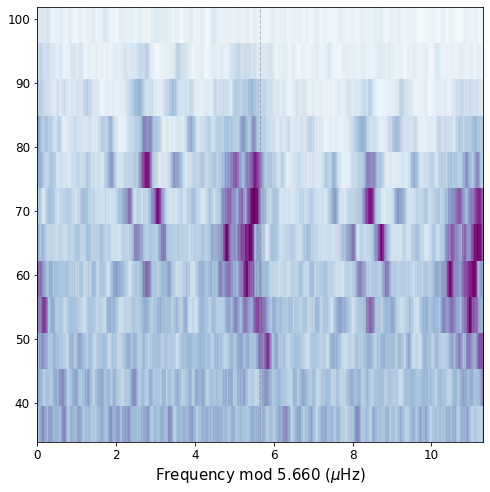

KIC 5631956
delta_nu = 4.774833095
nu_max = 49.4613275
returning dataframes


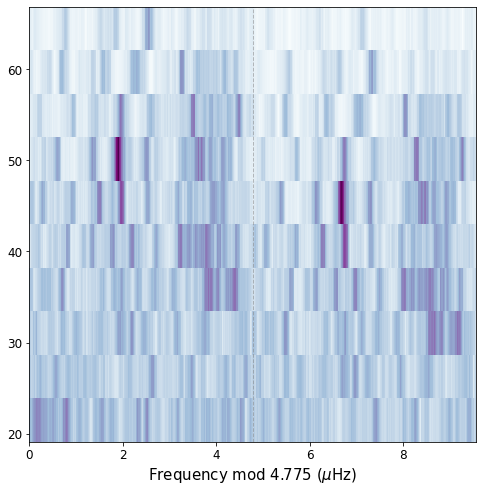

KIC 9245283
delta_nu = 3.866352639
nu_max = 42.31446186
returning dataframes


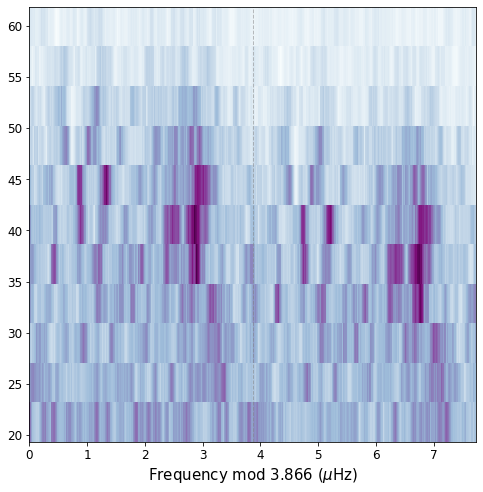

KIC 4059250
delta_nu = 5.018749079
nu_max = 57.23787078
returning dataframes


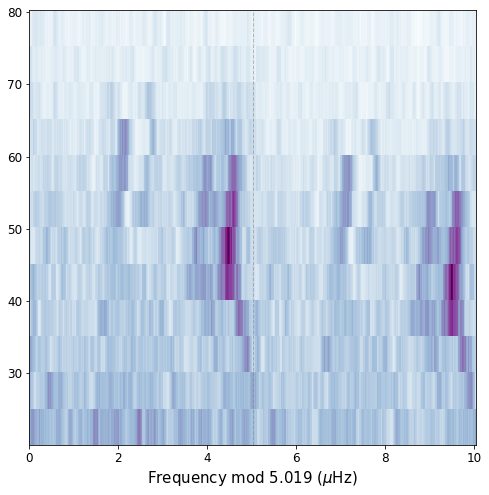

KIC 10322513
delta_nu = 7.174200746
nu_max = 92.29526485
returning dataframes


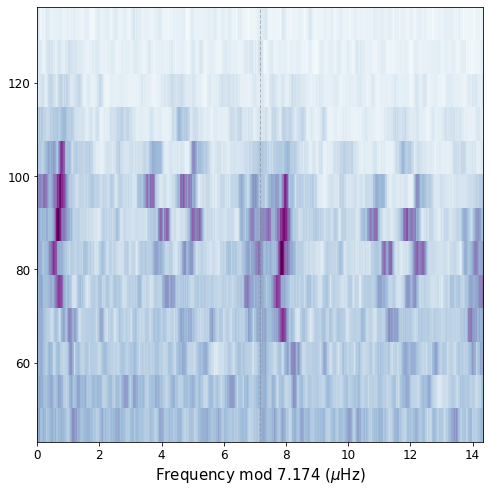

KIC 3120567
delta_nu = 5.419966961
nu_max = 65.17183398
returning dataframes


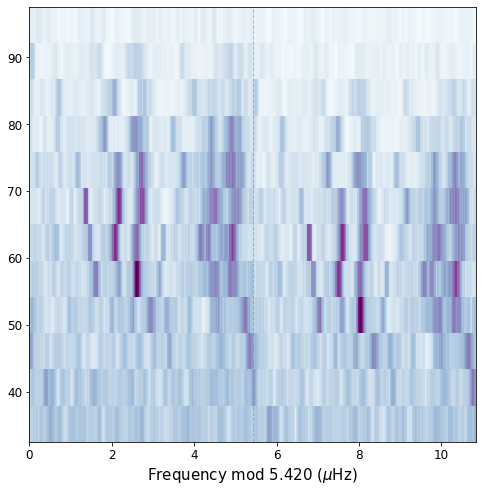

KIC 11234897
delta_nu = 5.189995261
nu_max = 58.85928554
returning dataframes


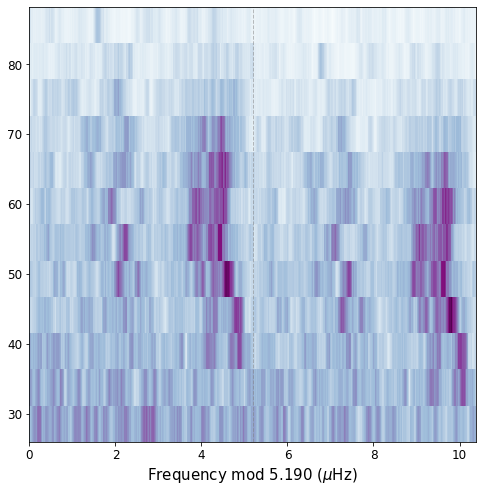

KIC 11297585
delta_nu = 3.31135704
nu_max = 33.75868941
returning dataframes


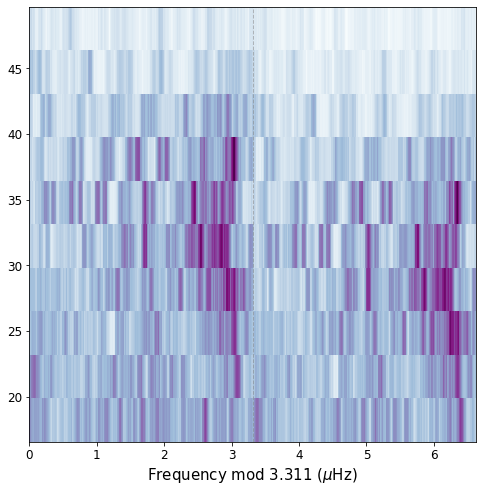

KIC 4940439
delta_nu = 5.798200854
nu_max = 72.23998574
returning dataframes


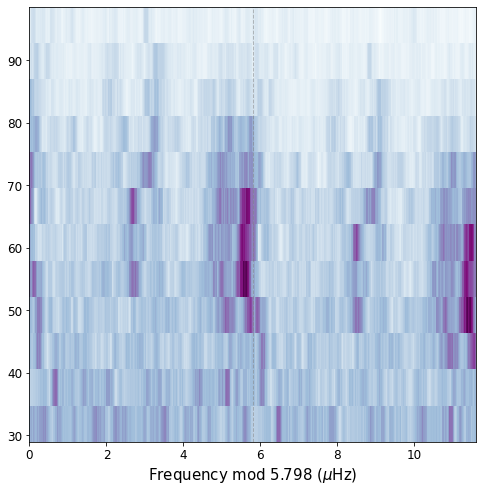

KIC 5307930
delta_nu = 4.472398231
nu_max = 51.20868891
returning dataframes


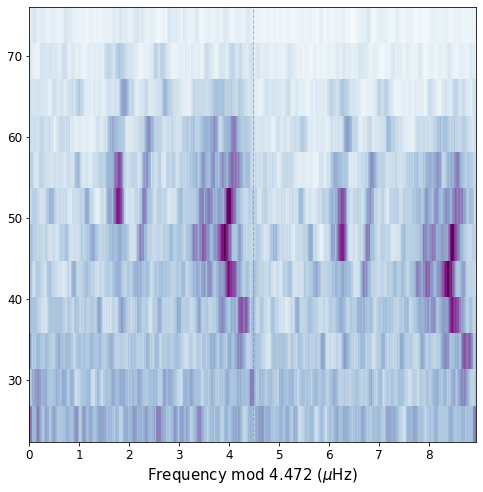

KIC 6438046
delta_nu = 3.052111287
nu_max = 31.34229796
returning dataframes


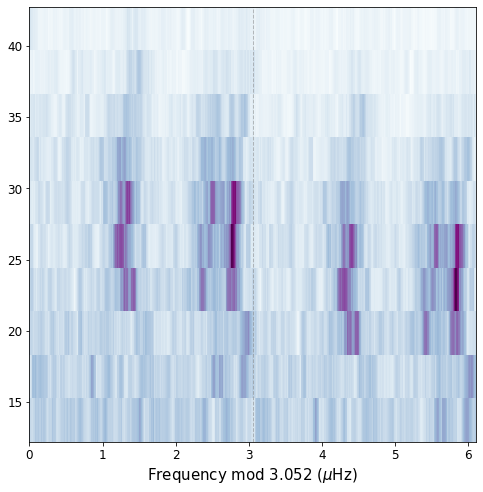

KIC 4348593
delta_nu = 5.154709108
nu_max = 61.7007231
returning dataframes


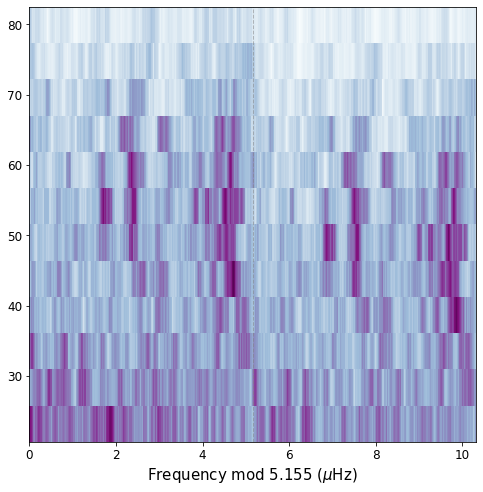

KIC 5731004
delta_nu = 6.451839073
nu_max = 81.13121643
returning dataframes


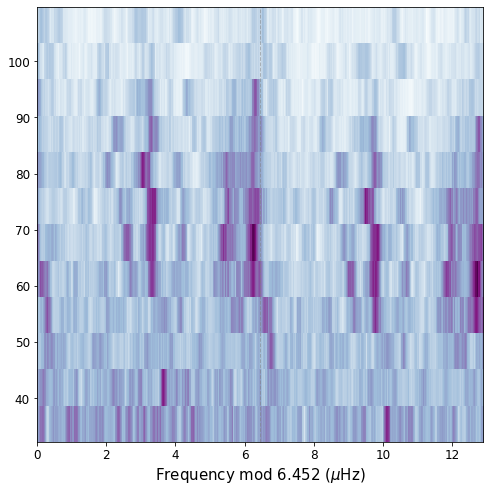

KIC 5734092
delta_nu = 5.135329493
nu_max = 60.61898319
returning dataframes


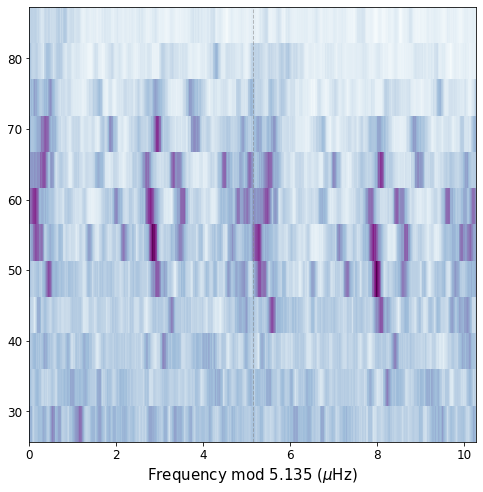

KIC 11235672
delta_nu = 11.25990984
nu_max = 73.81417244
returning dataframes


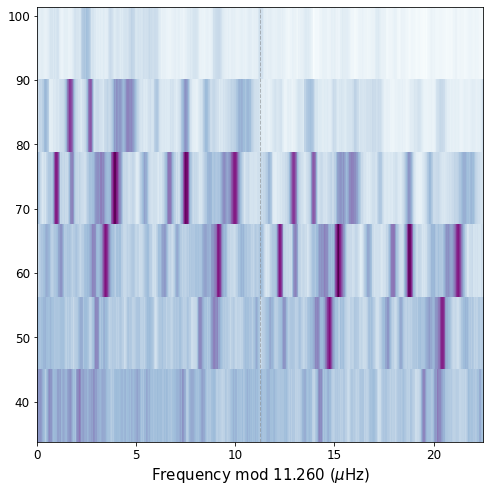

KIC 8230626
delta_nu = 7.942448123
nu_max = 109.6190669
returning dataframes


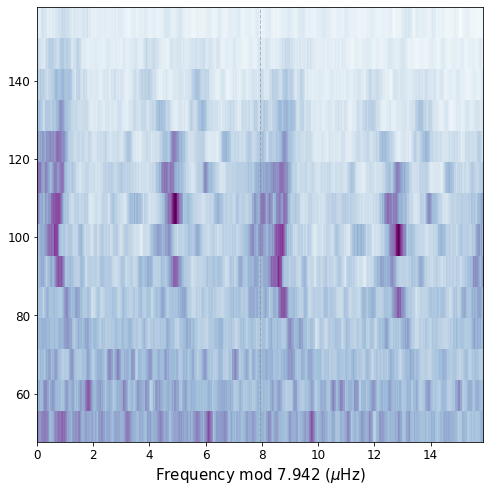

KIC 10600807
delta_nu = 4.92562089
nu_max = 53.30236636
returning dataframes


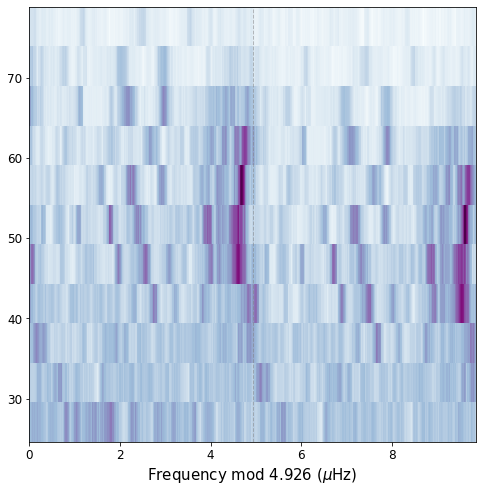

KIC 5080332
delta_nu = 6.742545102
nu_max = 84.33588972
returning dataframes


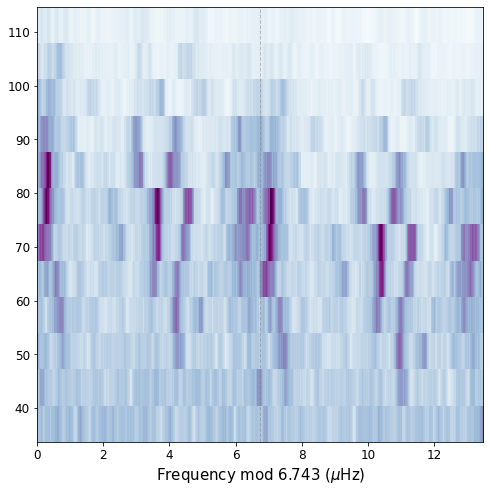

KIC 5531488
delta_nu = 7.970565236
nu_max = 103.4887592
returning dataframes


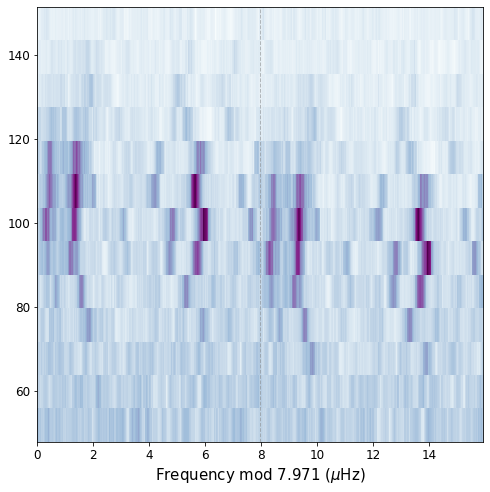

KIC 11413158
delta_nu = 5.003002463
nu_max = 59.04819055
returning dataframes


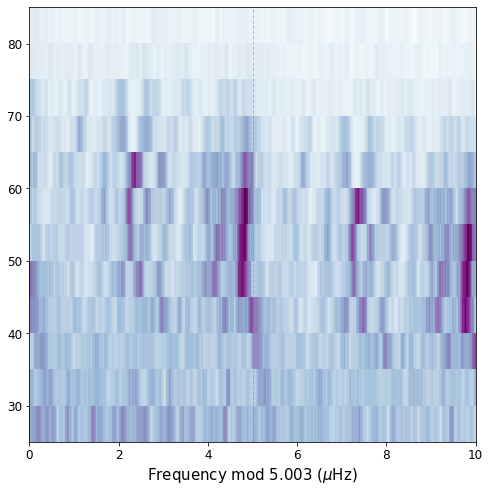

KIC 10918449
delta_nu = 3.676335148
nu_max = 38.59935048
returning dataframes


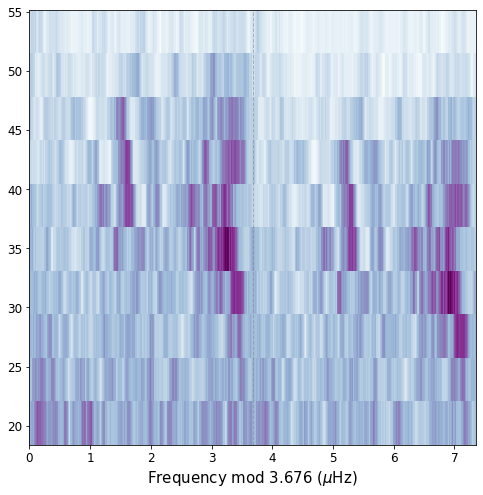

KIC 11044315
delta_nu = 5.237065516
nu_max = 61.6771031
returning dataframes


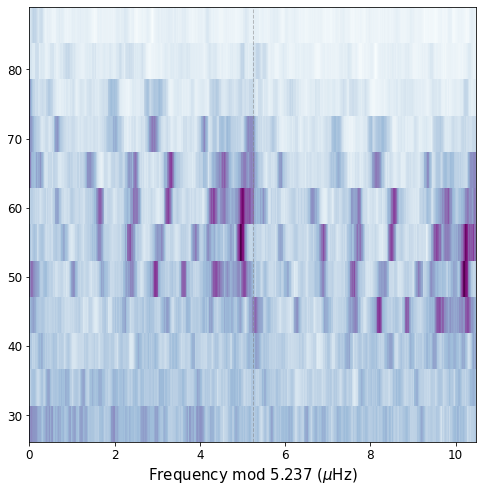

KIC 2834230
delta_nu = 7.063576148
nu_max = 86.87216418
returning dataframes


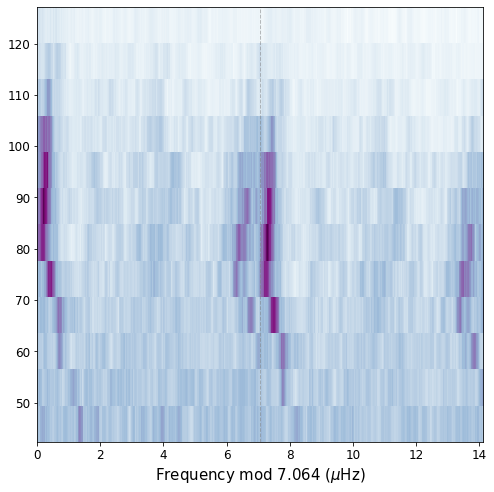

KIC 4273491
delta_nu = 5.700148012
nu_max = 70.22501162
returning dataframes


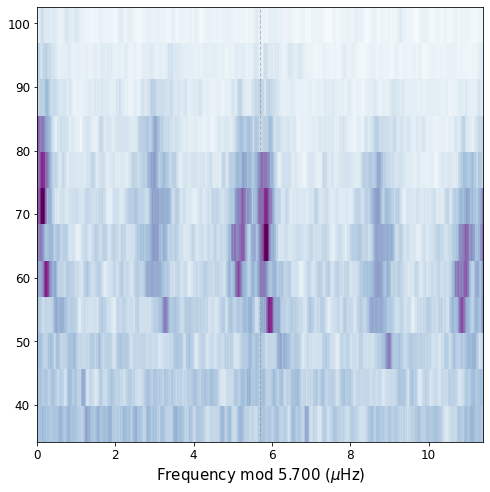

KIC 6694150
delta_nu = 6.421072606
nu_max = 79.77252397
returning dataframes


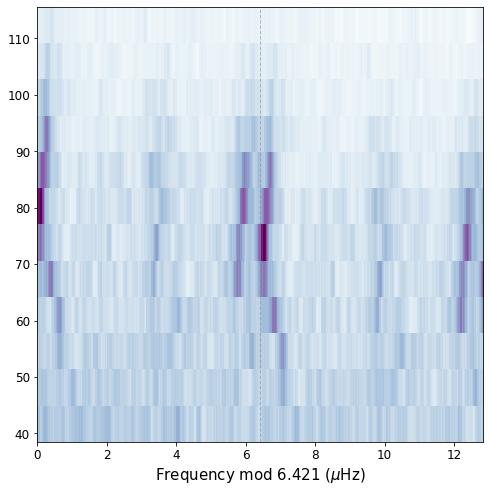

KIC 9468199
delta_nu = 4.886325191
nu_max = 57.54483356
returning dataframes


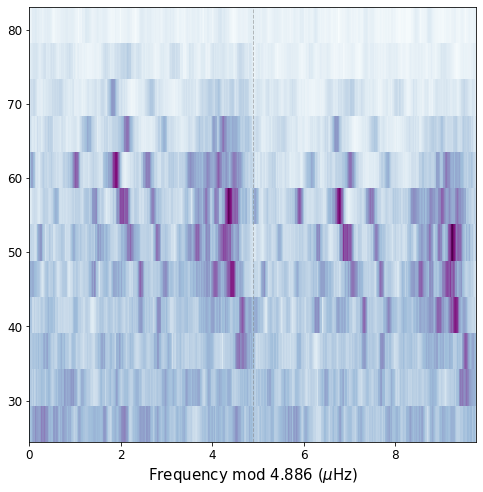

KIC 7901207
delta_nu = 6.491918062
nu_max = 81.65369012
returning dataframes


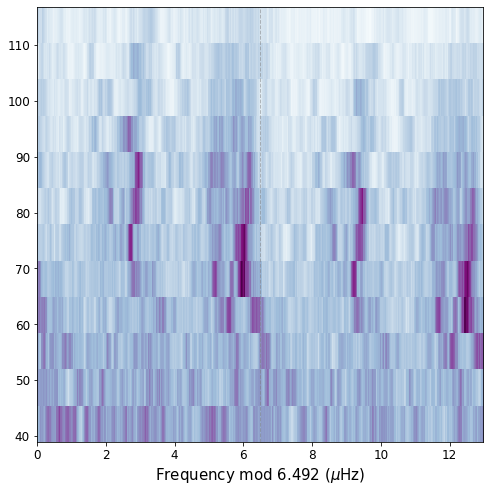

KIC 9612990
delta_nu = 5.141459349
nu_max = 59.11116173
returning dataframes


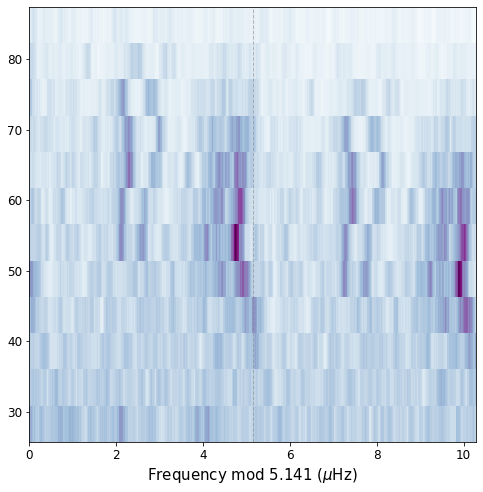

KIC 5380617
delta_nu = 4.044026179
nu_max = 43.84930897
returning dataframes


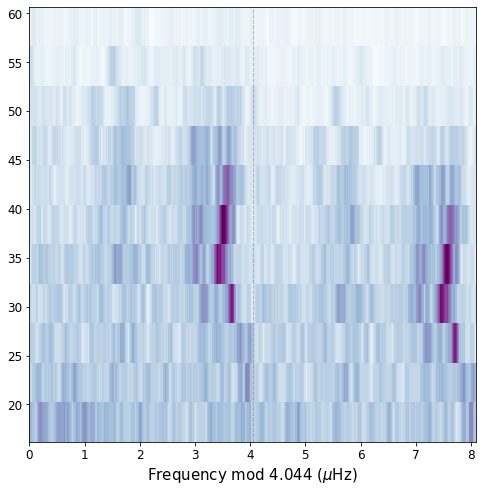

KIC 4372082
delta_nu = 6.229311355
nu_max = 79.37897776
returning dataframes


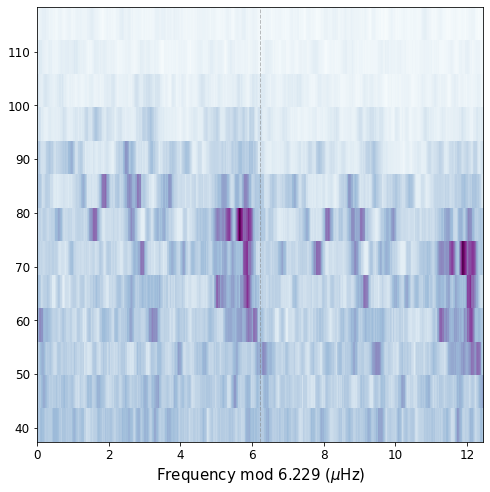

KIC 11405452
delta_nu = 4.718410579
nu_max = 52.60082713
returning dataframes


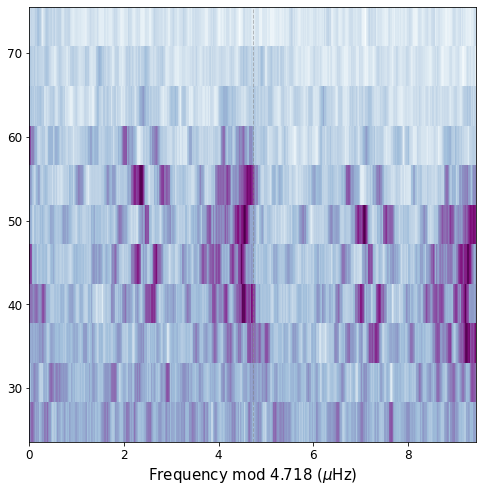

KIC 2158410
delta_nu = 4.290687885
nu_max = 46.83241728
returning dataframes


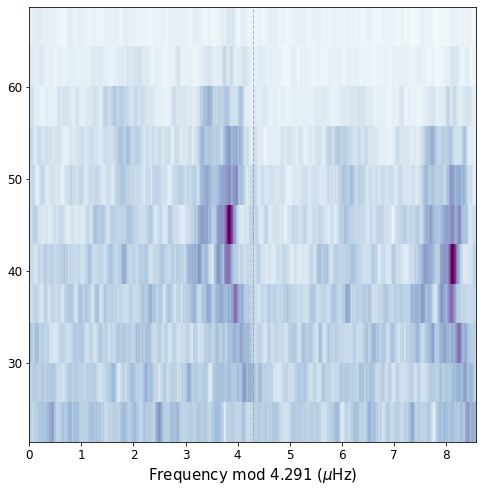

KIC 4055911
delta_nu = 5.243498646
nu_max = 59.64402266
returning dataframes


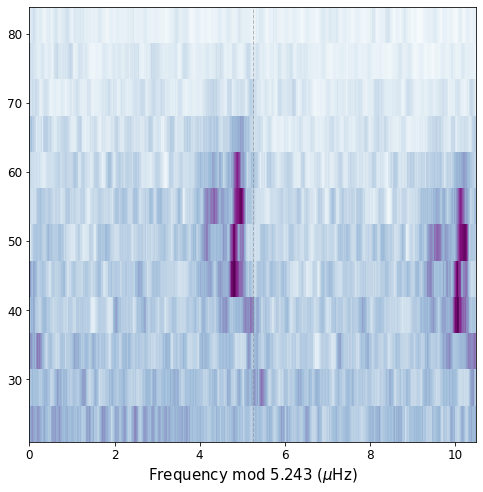

KIC 4756445
delta_nu = 6.124302753
nu_max = 74.50683206
returning dataframes


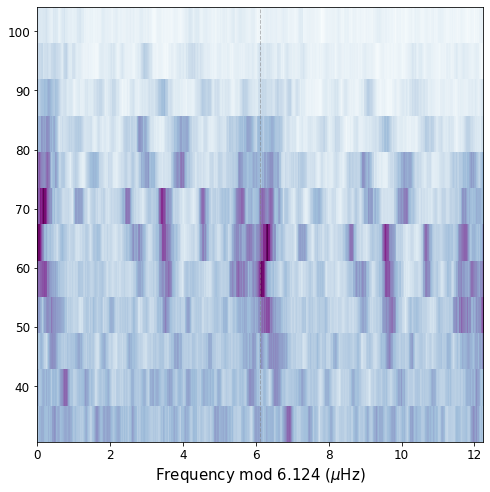

KIC 7757236
delta_nu = 5.563911775
nu_max = 61.92671851
returning dataframes


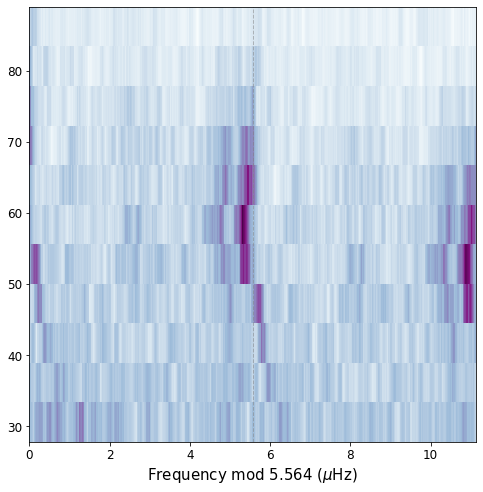

KIC 9451482
delta_nu = 6.689085281
nu_max = 81.85833032
returning dataframes


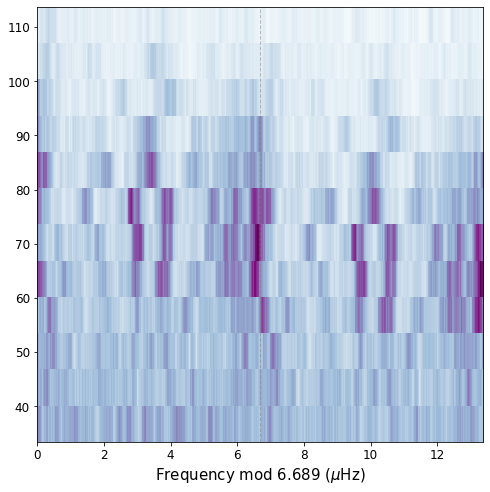

KIC 10809272
delta_nu = 5.231592463
nu_max = 59.06391959
returning dataframes


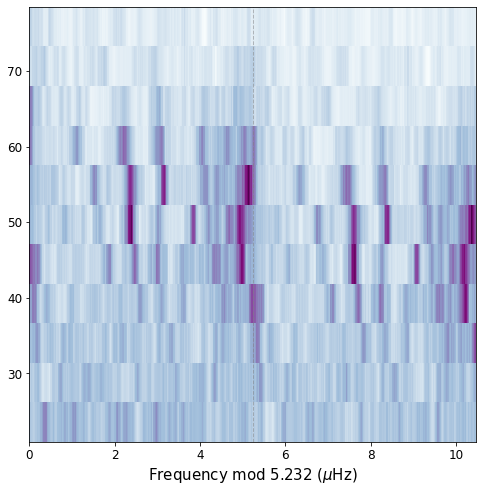

KIC 3432732
delta_nu = 6.414604814
nu_max = 80.42581978
returning dataframes


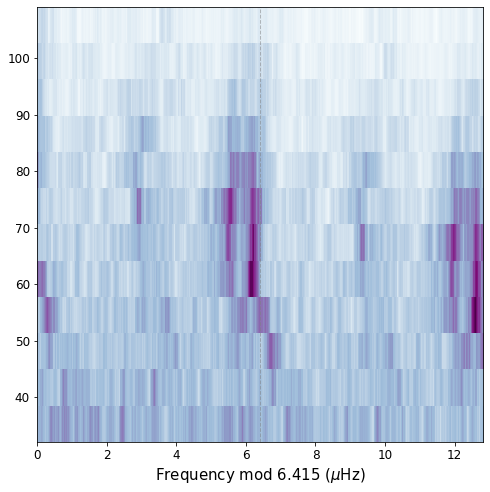

KIC 12164879
delta_nu = 4.786315047
nu_max = 54.38069006
returning dataframes


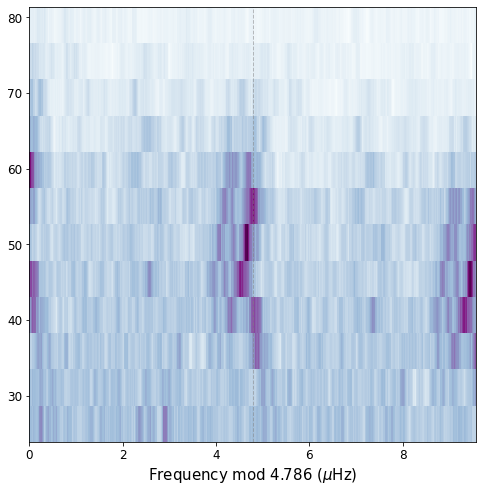

KIC 12453667
delta_nu = 7.707556098
nu_max = 99.17450813
returning dataframes


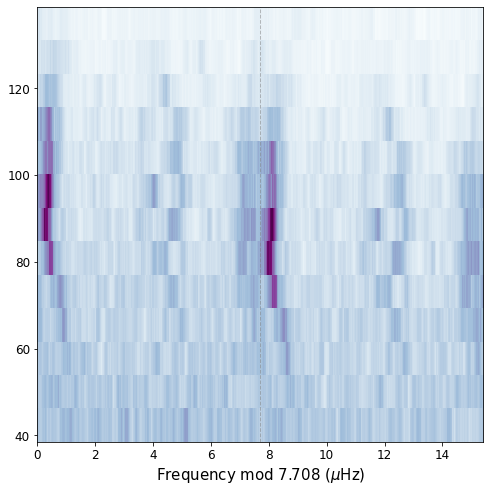

KIC 11619724
delta_nu = 2.486598524
nu_max = 23.65191048
returning dataframes


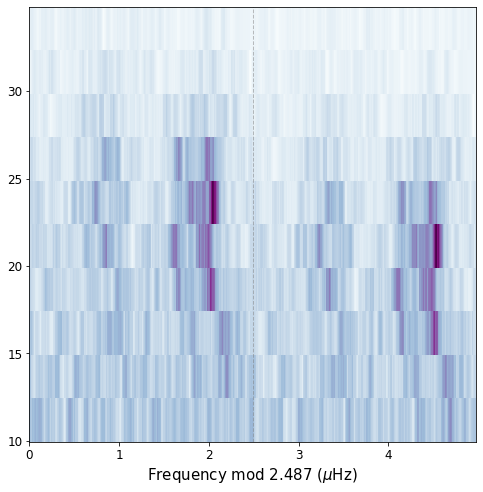

KIC 9786910
delta_nu = 2.384257616
nu_max = 22.36149255
returning dataframes


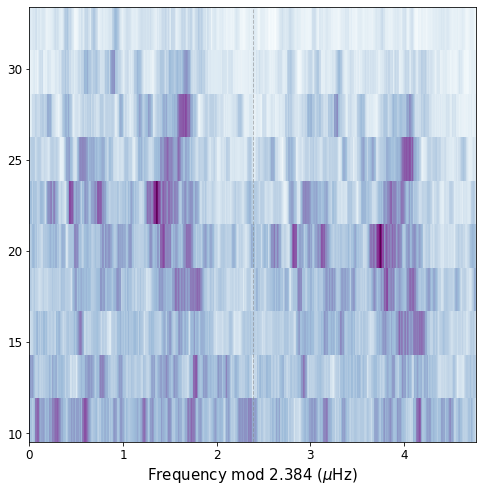

KIC 11456735
delta_nu = 7.007891798
nu_max = 90.28029054
returning dataframes


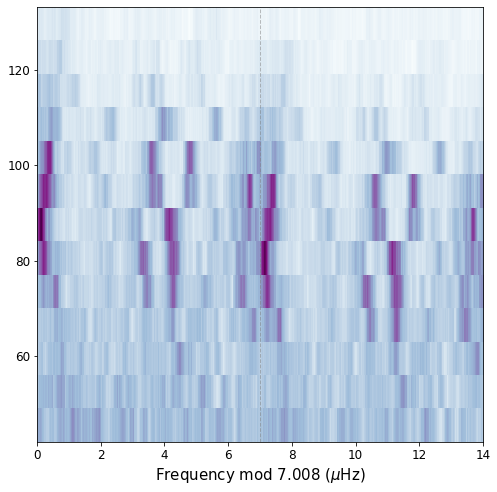

KIC 8025935
delta_nu = 5.865042095
nu_max = 70.48337297
returning dataframes


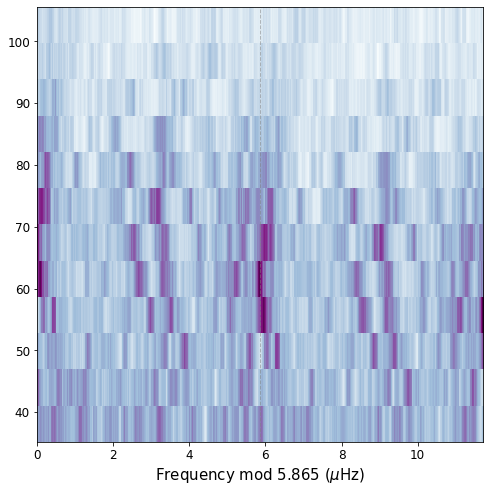

KIC 9266192
delta_nu = 6.340891835
nu_max = 88.65886875
returning dataframes


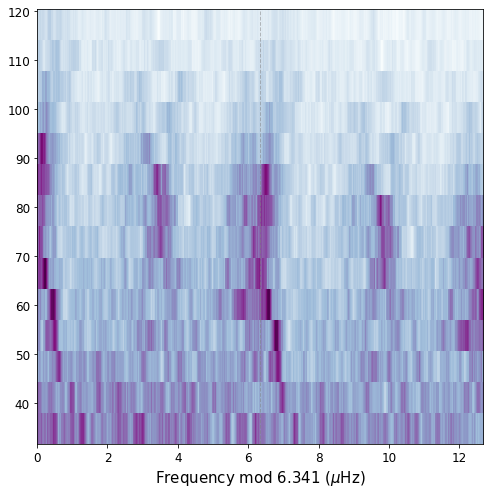

KIC 7350769
delta_nu = 7.104536459
nu_max = 88.94222959
returning dataframes


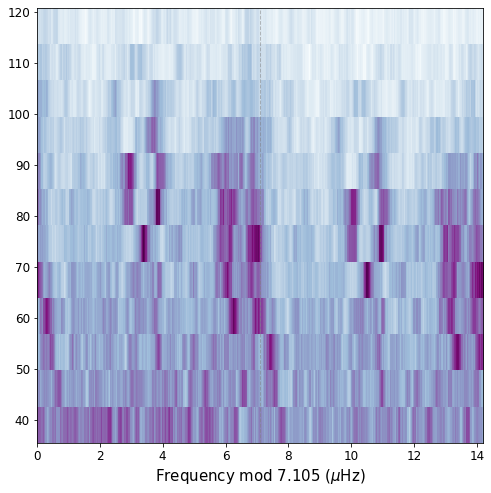

KIC 7581399
delta_nu = 6.595023163
nu_max = 83.28298191
returning dataframes


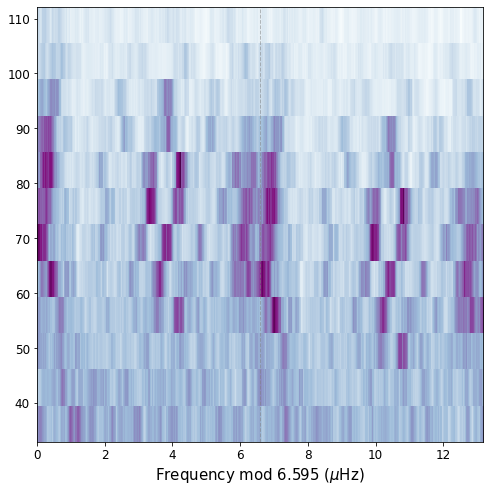

KIC 8508931
delta_nu = 5.018508331
nu_max = 59.4921547
returning dataframes


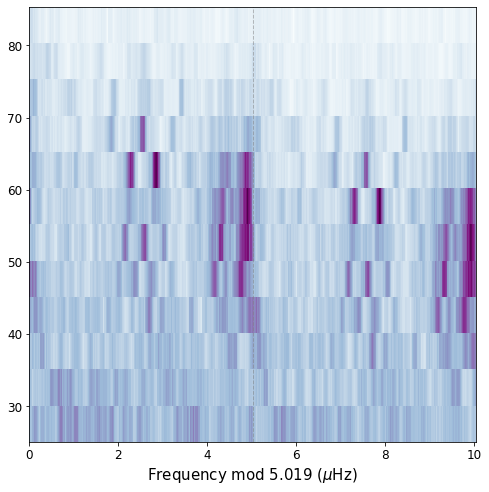

KIC 4940935
delta_nu = 3.810197694
nu_max = 39.93742509
returning dataframes


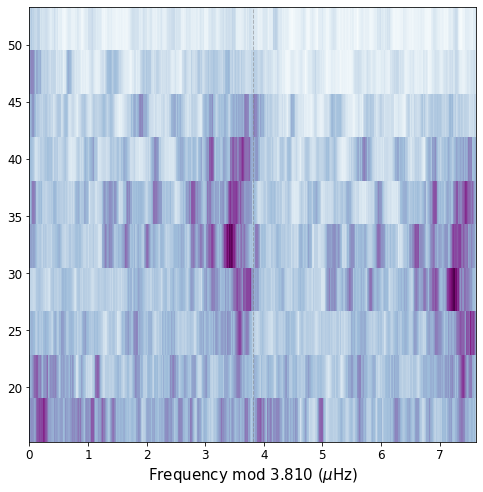

KIC 5534910
delta_nu = 8.153363217
nu_max = 109.4933995
returning dataframes


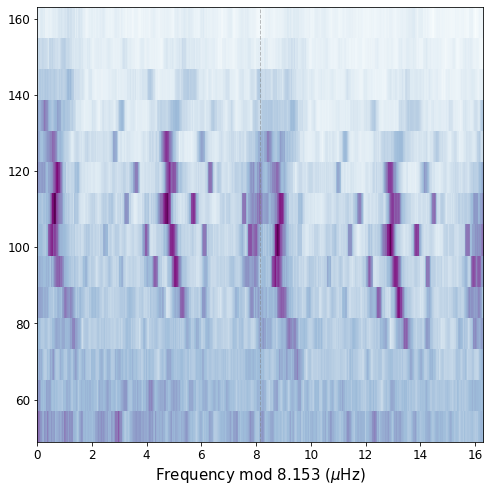

KIC 6756648
delta_nu = 6.697119666
nu_max = 81.67874551
returning dataframes


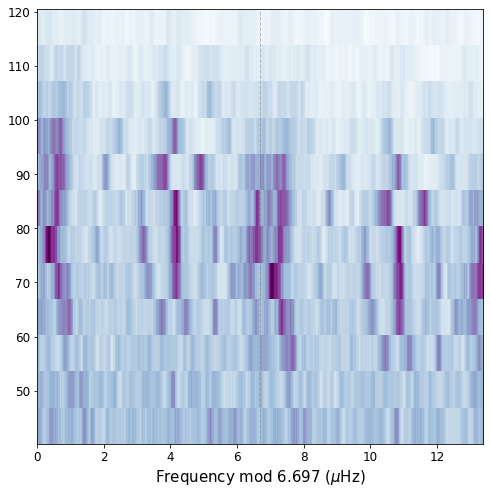

KIC 10989210
delta_nu = 4.679749528
nu_max = 51.84623263
returning dataframes


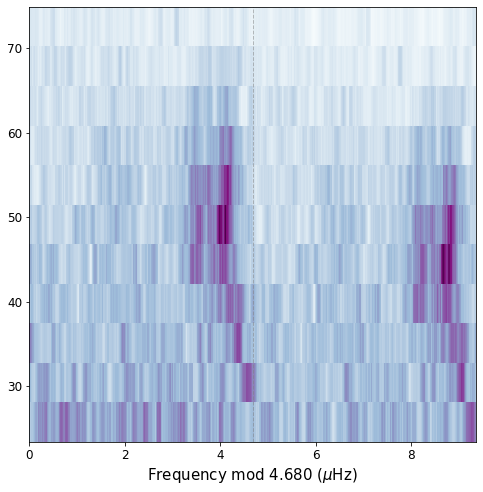

KIC 12020628
delta_nu = 6.977722738
nu_max = 88.41486408
returning dataframes


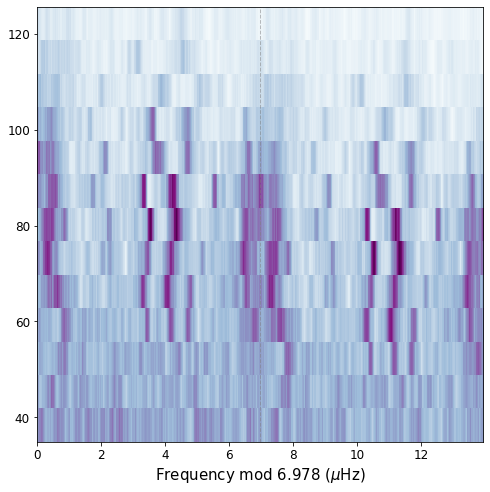

KIC 9846437
delta_nu = 1.734473101
nu_max = 15.56421253
returning dataframes


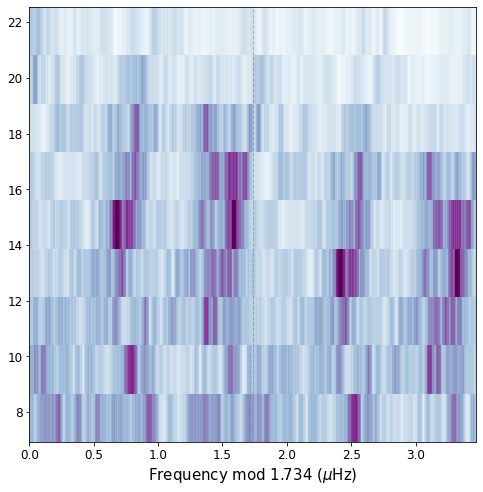

KIC 10621713
delta_nu = 3.372937979
nu_max = 34.86679298
returning dataframes


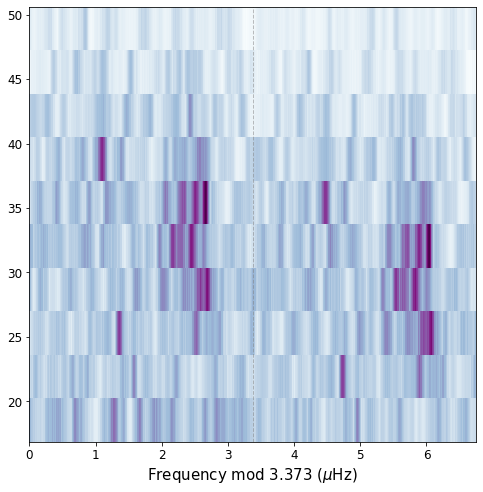

KIC 3758731
delta_nu = 6.24079082
nu_max = 75.87638623
returning dataframes


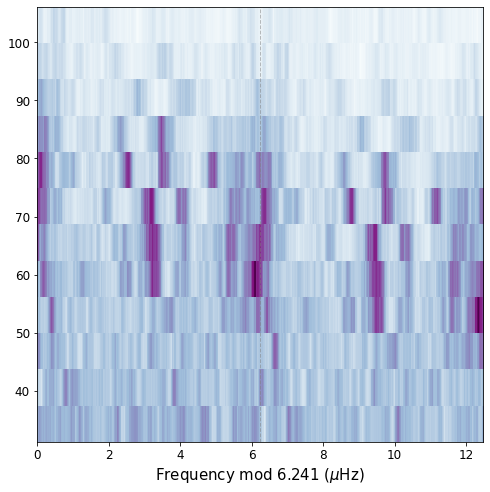

KIC 8395466
delta_nu = 5.694619199
nu_max = 67.36783606
returning dataframes


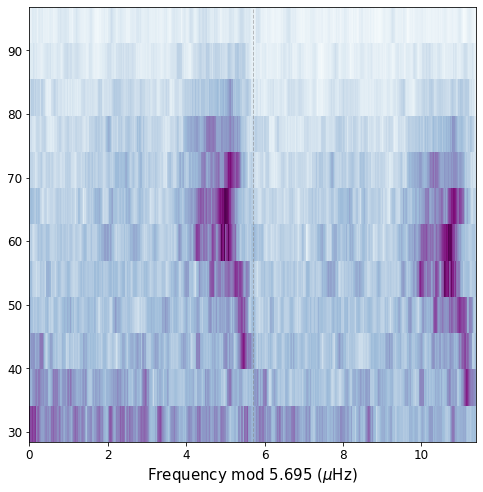

KIC 7052311
delta_nu = 4.717993959
nu_max = 52.81436978
returning dataframes


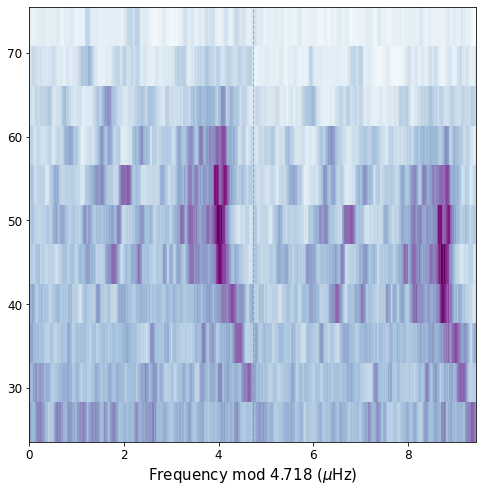

KIC 8107227
delta_nu = 6.077266666
nu_max = 72.8303057
returning dataframes


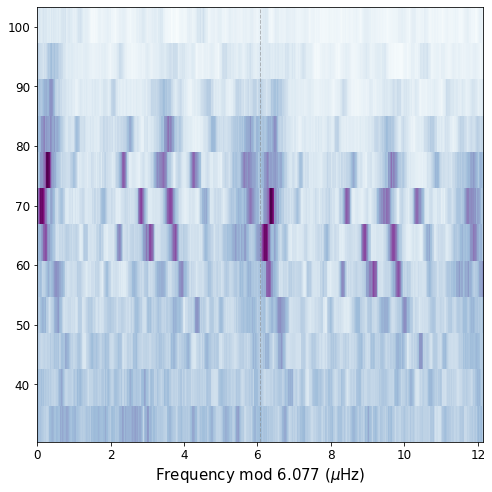

KIC 9655167
delta_nu = 8.051316798
nu_max = 104.7865362
returning dataframes


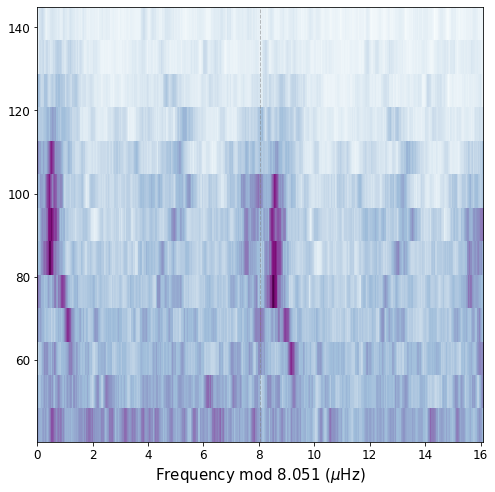

KIC 12603148
delta_nu = 4.84201334
nu_max = 56.26972714
returning dataframes


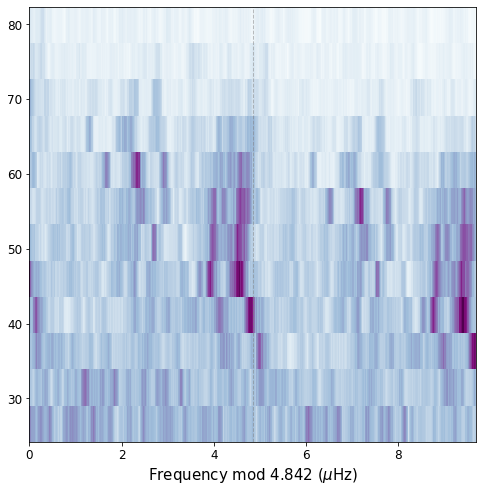

KIC 2984102
delta_nu = 5.581774708
nu_max = 64.8333809
returning dataframes


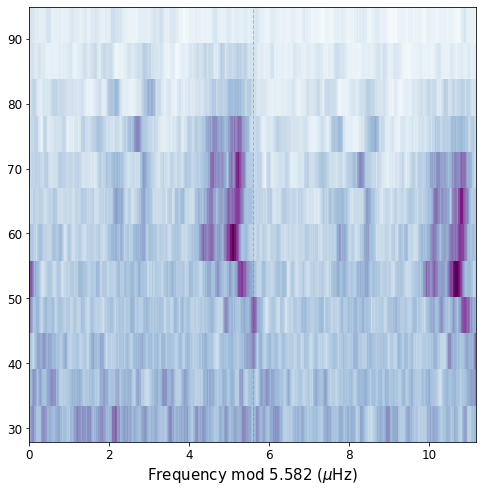

KIC 9655101
delta_nu = 7.882247257
nu_max = 99.86716532
returning dataframes


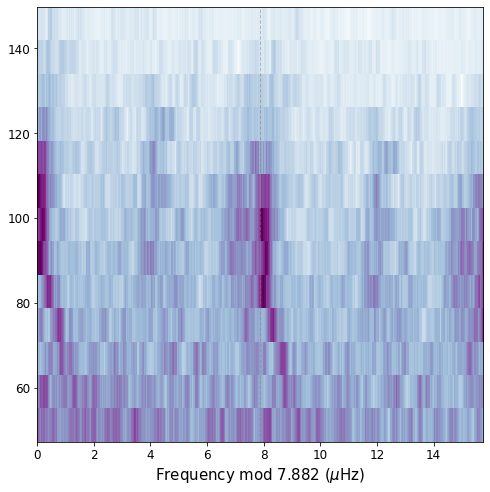

KIC 4179377
delta_nu = 2.697236328
nu_max = 25.89714969
returning dataframes


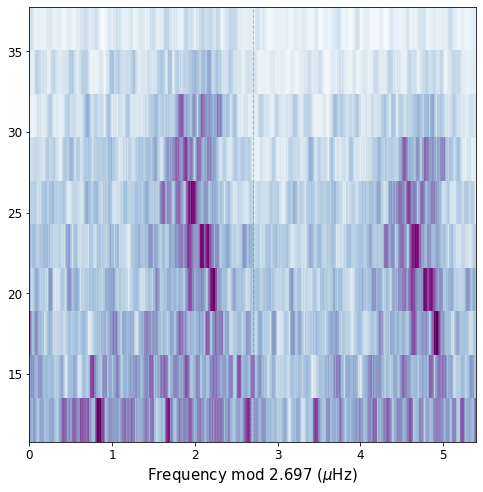

KIC 5707338
delta_nu = 6.396973955
nu_max = 80.64620586
returning dataframes


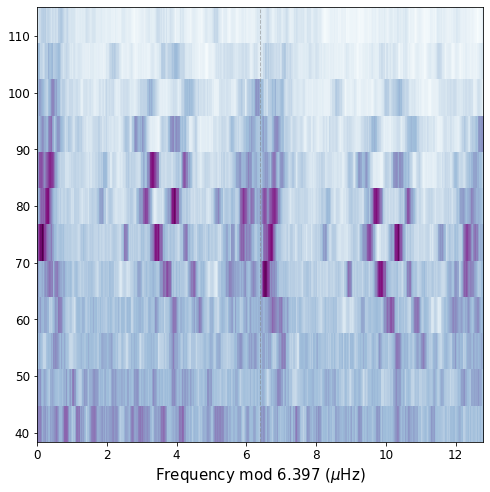

KIC 2845610
delta_nu = 7.107551257
nu_max = 92.31102247
returning dataframes


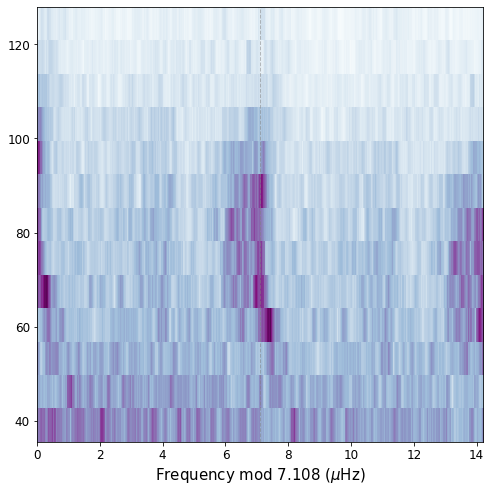

KIC 5104175
delta_nu = 7.076638518
nu_max = 89.39168558
returning dataframes


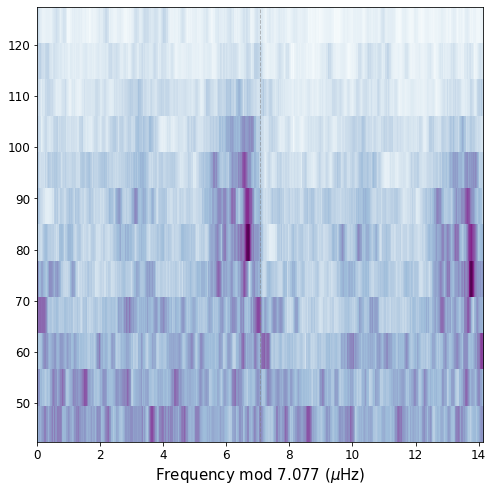

KIC 9836930
delta_nu = 5.946770798
nu_max = 73.26320704
returning dataframes


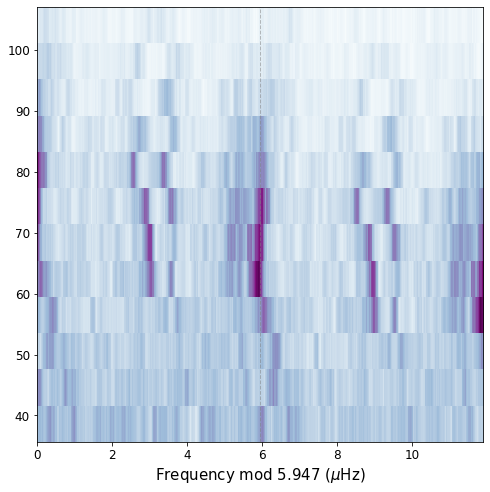

KIC 3660976
delta_nu = 3.85759814
nu_max = 40.22865258
returning dataframes


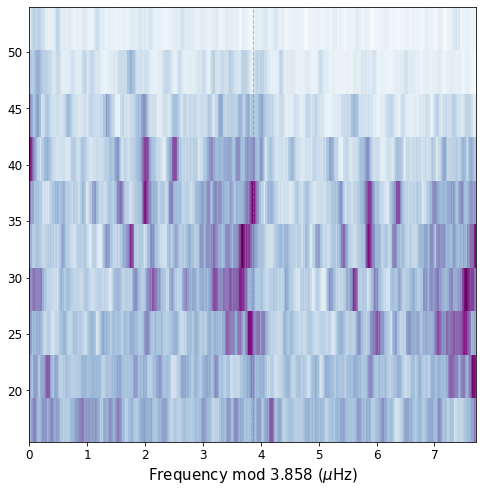

KIC 6382830
delta_nu = 2.518467343
nu_max = 22.92820582
returning dataframes


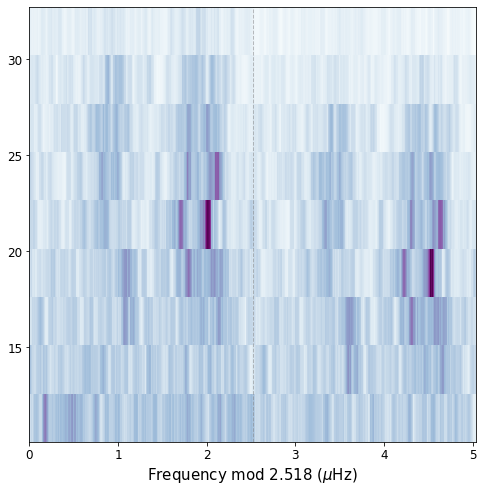

KIC 7708681
delta_nu = 6.319821556
nu_max = 78.45806749
returning dataframes


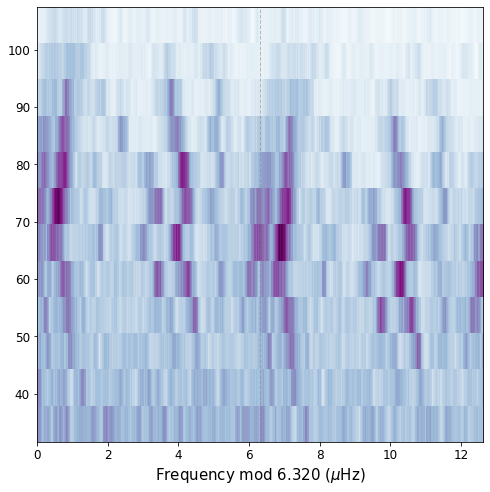

KIC 4651366
delta_nu = 4.652537294
nu_max = 52.62546739
returning dataframes


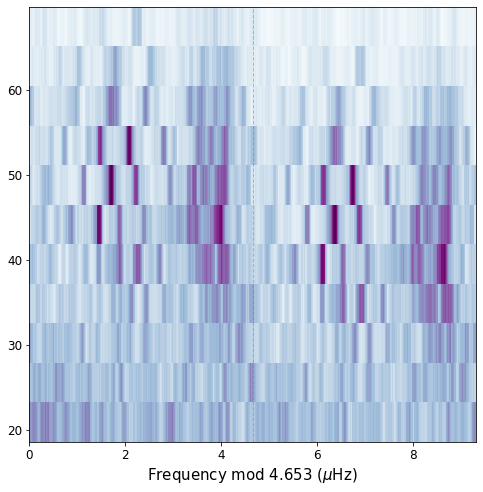

KIC 8232262
delta_nu = 5.978852802
nu_max = 73.49933923
returning dataframes


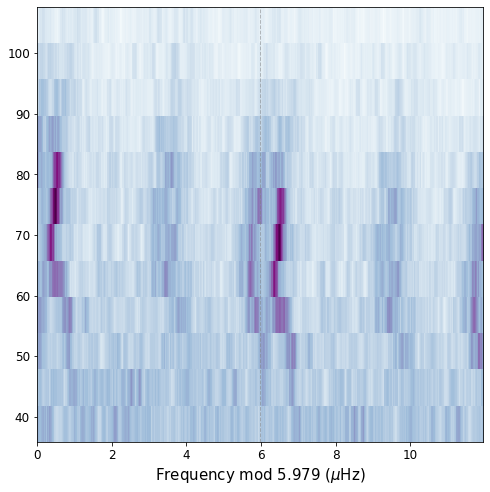

KIC 9226335
delta_nu = 4.53441698
nu_max = 50.42158496
returning dataframes


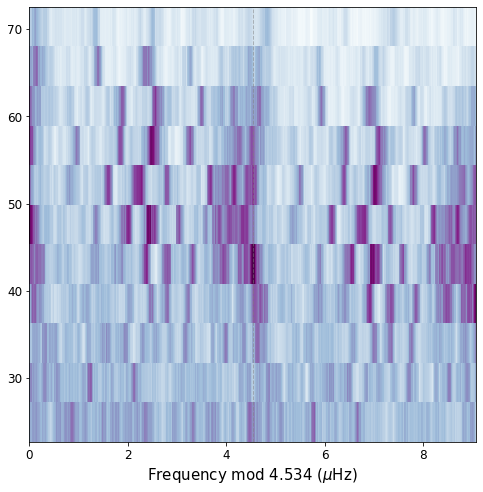

KIC 11045134
delta_nu = 4.384198363
nu_max = 49.83912925
returning dataframes


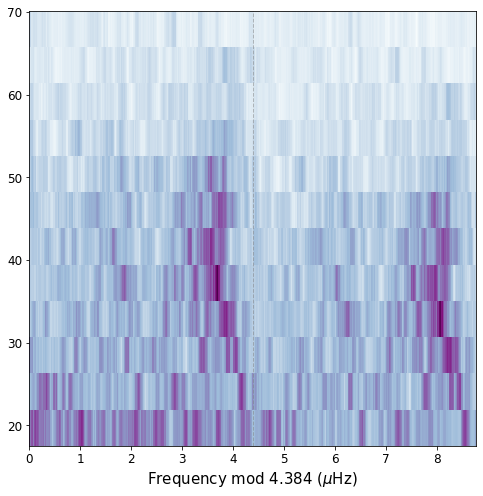

KIC 2860936
delta_nu = 7.643779893
nu_max = 98.32446318
returning dataframes


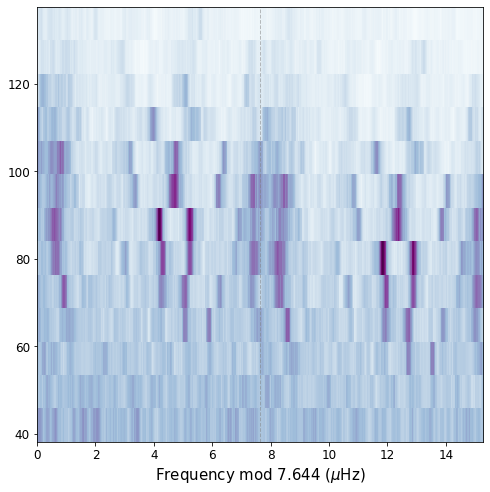

KIC 10162765
delta_nu = 6.801790911
nu_max = 85.50260178
returning dataframes


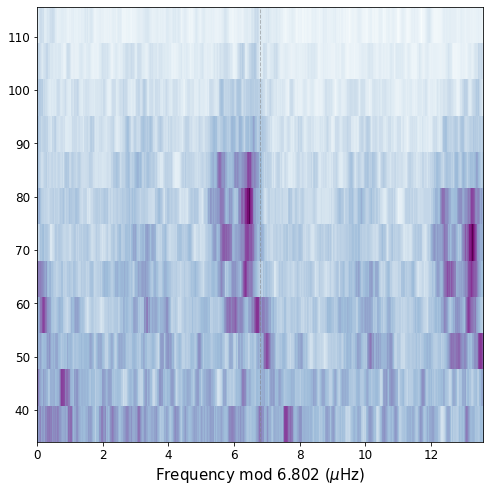

KIC 3430048
delta_nu = 3.518327282
nu_max = 33.62687497
returning dataframes


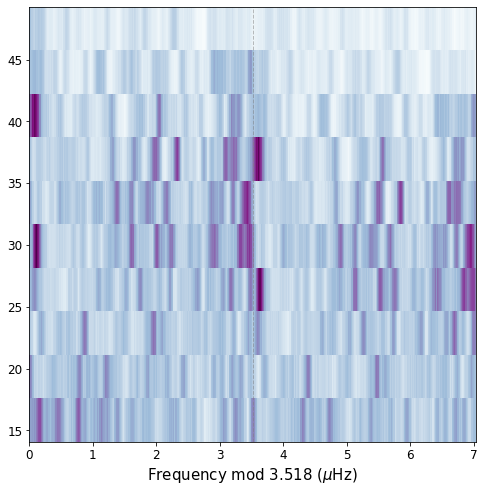

KIC 7116721
delta_nu = 4.514955516
nu_max = 50.98829849
returning dataframes


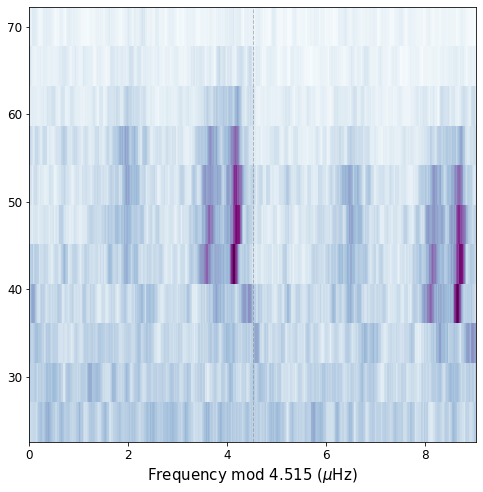

KIC 7347076
delta_nu = 7.217618953
nu_max = 90.71324193
returning dataframes


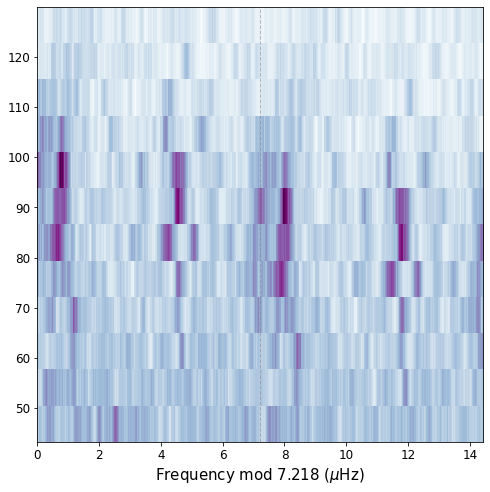

KIC 10163776
delta_nu = 6.166957297
nu_max = 74.76656675
returning dataframes


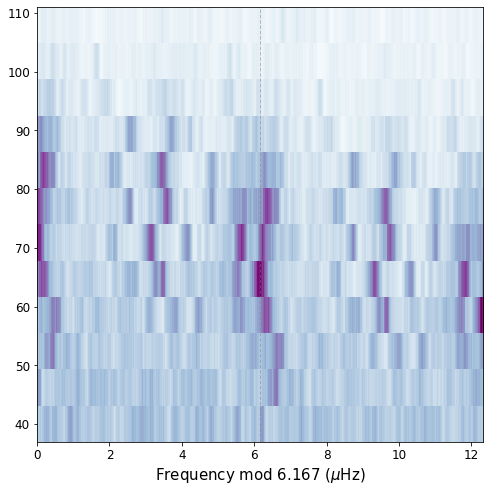

In [33]:
for i in range(0,len(highmass_rc_newvals)):
    star_name = 'KIC '+str(highmass_rc_newvals['KIC'][i])
    if star_name not in ['KIC 2579142','KIC 4060757']:
        delta_nu,nu_max,lightcurve,powerspec = read_star_hp(star_name,suppress_output=False)
    #     delta_nu = 5.946
        echelle_wrapper(freq=np.asarray(powerspec['freq']),power=np.asarray(powerspec['power']),
                 dnu=delta_nu,
                 fmin=(0.5*nu_max),fmax=(1.5*nu_max),smooth_percent=0.02)
        plt.show()

In [27]:
i=47
star_name = 'KIC '+str(highmass_rc_newvals['KIC'][i])
delta_nu,nu_max,lightcurve,powerspec = read_star_hp(star_name,suppress_output=False)
delta_nu = 5.946
interact(echelle_wrapper,freq=fixed(np.asarray(powerspec['freq'])),power=fixed(np.asarray(powerspec['power'])),
         dnu=FloatSlider(min=delta_nu-0.5,max=delta_nu+0.5,step=0.005,value=delta_nu),
         fmin=fixed(0.5*nu_max),fmax=fixed(1.5*nu_max),smooth_percent=fixed(0.02))

KIC 11235672
delta_nu = 11.25990984
nu_max = 73.81417244
returning dataframes


interactive(children=(FloatSlider(value=5.946, description='dnu', max=6.446, min=5.446, step=0.005), Output())…

<function __main__.echelle_wrapper(freq, power, dnu, fmin, fmax, smooth_percent=0.02)>

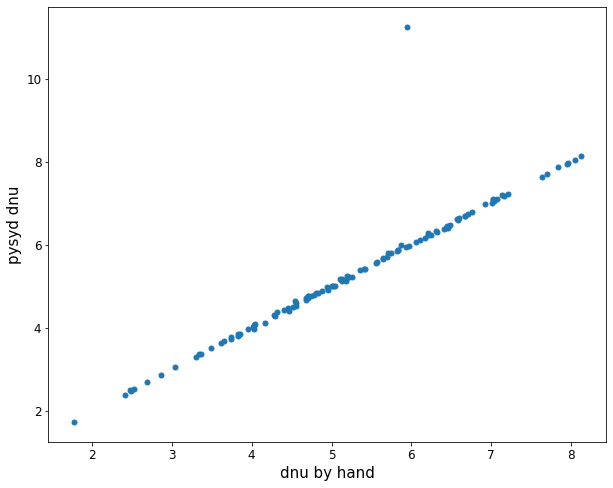

In [13]:
plt.scatter(highmass_rc_newvals['Delnu'],highmass_rc_newvals['pysyd_dnu'])
plt.xlabel('dnu by hand')
plt.ylabel('pysyd dnu')
plt.show()

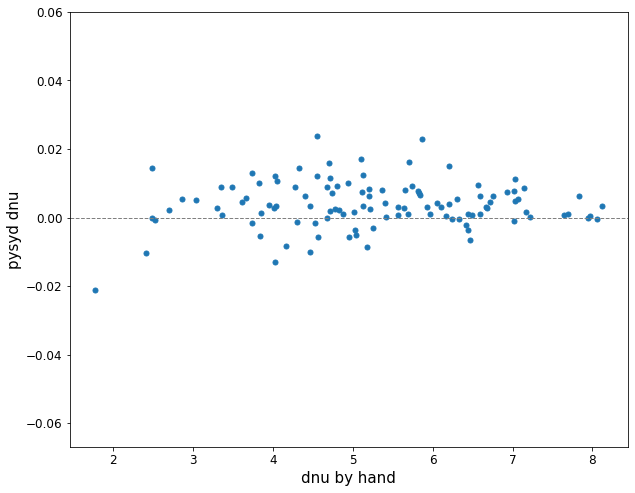

In [16]:
plt.scatter(highmass_rc_newvals['Delnu'],
            (highmass_rc_newvals['pysyd_dnu']-highmass_rc_newvals['Delnu'])/highmass_rc_newvals['Delnu'])
plt.axhline(0,color='grey',linestyle='--')
plt.xlabel('dnu by hand')
plt.ylabel('pysyd dnu')
plt.ylim(top=0.06)
plt.show()